In [3]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sc
from scipy import signal
from scipy import interpolate as interp
import scipy.ndimage
import matplotlib.pylab as pl
import time
import cv2 as cv
import ot
import math

# Define SW and SW grad with projections as entry

In [4]:
def SW_gradSW(u,v,Teta):#Pour deux images de même taille 
    N = u.shape[0]
    M = u.shape[1]
    d = u.shape[2]
    
    nbProj = Teta.shape[0]
    
    SW = 0
    gradSW = np.zeros((N,M,d))
    
    for i in range(nbProj):
        uteta = np.zeros(N*M)
        vteta = np.zeros(N*M)
        for j in range(N*M):#np.int(np.floor(i/M)), np.int(i - np.floor(i/M)*M)
            uteta[j] = np.dot(u[np.int(np.floor(j/M)), np.int(j - np.floor(j/M)*M)], Teta[i])
            vteta[j] = np.dot(v[np.int(np.floor(j/M)), np.int(j - np.floor(j/M)*M)], Teta[i])
        u_sorted = np.sort(uteta)
        v_sorted = np.sort(vteta)
        Iu_sorted = np.argsort(uteta)
        Iv_sorted = np.argsort(vteta)
        SW = SW + np.sum((u_sorted - v_sorted)**2)
        sigma = np.zeros(N*M)
        sigma[Iu_sorted] = Iv_sorted
        
        for j in range(N*M):
                gradSW[np.int(np.floor(j/M)), np.int(j - np.floor(j/M)*M)] = gradSW[np.int(np.floor(j/M)), np.int(j - np.floor(j/M)*M)] + np.dot(u[np.int(np.floor(j/M)), np.int(j - np.floor(j/M)*M)] - v[np.int(np.floor(sigma[j]/M)), np.int(sigma[j] - np.floor(sigma[j]/M)*M)], Teta[i])*Teta[i]
        
    SW = SW/nbProj
    
    return SW, gradSW

# Preparation Data

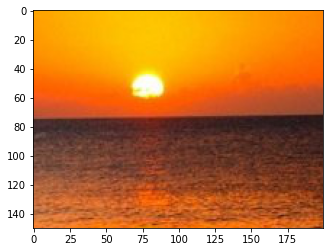

In [5]:
I1 = plt.imread('../data/coucher.jpg')
Xtrue = I1[100:250, 450:650, :]/255
plt.imshow(Xtrue)

In [6]:
def spectrale_degradation(img, b_low, b_high, adjoint):
    if(adjoint == 0):
        d = img.shape[2]
        out = np.zeros((img.shape[0], img.shape[1], b_low))
        for i in range(b_low):
            for j in range(d):
                out[:,:,i] = out[:,:,i] + img[:,:,j]
            
            out[:,:,i] = out[:,:,i]/d
        return out
    else :
        d = img.shape[2]
        out = np.zeros((img.shape[0], img.shape[1], b_high))
        for i in range(b_high):
            out[:,:,i] = 1/3*img[:,:,0]
        return out  

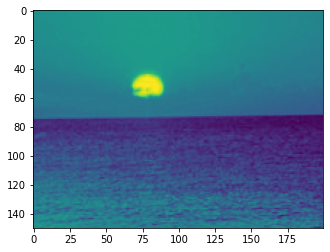

In [7]:
L_M = spectrale_degradation(Xtrue, 1, 3, 0)
plt.imshow(L_M)

In [8]:
def spatial_degradation(img,K,adjoint):
    sx , sy, d = img.shape[0], img.shape[1], img.shape[2]
    GaussBlur = cv.getGaussianKernel(5,5)
    GaussBlur_adj = GaussBlur.transpose()
        
    if adjoint==0: #Blur de l'image + sous-echantillonnage 
        imgBlurred = cv.filter2D(img, -1, GaussBlur)#Blur de l'image
        #Sous-echantillonnage
        Sx = math.floor(sx/K)
        Sy = math.floor(sy/K)
        out = np.zeros([Sx,Sy,d])
        for x in range(Sx):
            for y in range(Sy):
                tmp=0
                for k in range(K):
                    for l in range(K):
                        tmp += imgBlurred[K*x+k,K*y+l, :]
                out[x,y,:]=tmp
                
    else: #sur-echantillonnage + Adjoint Blur (convolution avec transposee du Kernel de Blur)
        Sx = sx*K
        Sy = sy*K
        out = np.zeros([Sx,Sy,d])
        for x in range(sx):
            for y in range(sy):
                for k in range(K):
                    for l in range(K):
                        out[K*x+k,K*y+l]= img[x,y]
        out = cv.filter2D(out, -1, GaussBlur_adj)#Adjoint du Blur
    
    return out/(K*K)

In [9]:
L_H = spatial_degradation(Xtrue, 2, 0)

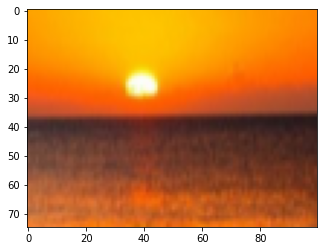

In [10]:
plt.imshow(L_H)

In [11]:
def reech_interp(img, K_ech):
    imgRec = np.zeros((K_ech*img.shape[0], K_ech*img.shape[1], img.shape[2]))
    for i in range(img.shape[2]):
        imgRec[:,:,i] = scipy.ndimage.zoom(img[:,:,i], K_ech, order=3)
    return imgRec

In [12]:
import skimage
from skimage import data, img_as_float
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import mean_squared_error

In [13]:
def PSNR(reference, reconstruct):
    mse = np.mean((reference - reconstruct) ** 2)
    if(mse == 0):  
        return 100
    max_pixel = 255.0
    psnr = 20 * np.log10(max_pixel / np.sqrt(mse))
    return psnr

In [14]:
def aSAM(reference, reconstruct):
    N = reference.shape[0]
    M = reference.shape[1]
    asam = 0
    for j in range(N*M):
        ps = np.dot(reference[np.int(np.floor(j/M)), np.int(j - np.floor(j/M)*M)], reconstruct[np.int(np.floor(j/M)), np.int(j - np.floor(j/M)*M)].transpose())
        norm = np.linalg.norm(reference[np.int(np.floor(j/M)), np.int(j - np.floor(j/M)*M)])*np.linalg.norm(reconstruct[np.int(np.floor(j/M)), np.int(j - np.floor(j/M)*M)])
        asam = asam + np.arccos(ps/norm)
    asam = asam/(N*M)
    return asam

In [15]:
def acSSIM(reference, reconstruct):
    l = reference.shape[2]
    acssim = 0
    for i in range(l):
        acssim = acssim + skimage.metrics.structural_similarity(reference[:,:,i], reconstruct[:,:,i])
    acssim = 1 - acssim/l
    return acssim    

# Descente de Gradient avec projections fixées aléatoirement

In [16]:
def Fct_gradFct(X, L_H, L_M, K_ech, b_low, b_high, Lbd_SW1, Lbd_SW2, mu, Teta_H, Teta_M):
    SW1, Gradient1 = SW_gradSW(spatial_degradation(X, K_ech, 0), L_H, Teta_H)
    SW2, Gradient2 = SW_gradSW(spectrale_degradation(X, b_low, b_high, 0), L_M, Teta_M)

    L2 = np.linalg.norm(X-reech_interp(L_H, K_ech))**2
    
    Gradient_quad = 2*(X-reech_interp(L_H, K_ech))
    Gradient1 = spatial_degradation(Gradient1, K_ech, 1)
    Gradient2 = spectrale_degradation(Gradient2, b_low, b_high, 1)
    grad = Lbd_SW1*Gradient1 + Lbd_SW2*Gradient2 + mu*Gradient_quad
    
    Fct = Lbd_SW1*SW1 + Lbd_SW2*SW2 + mu*L2
    
    return Fct, grad, Lbd_SW1*SW1, Lbd_SW2*SW2, mu*L2


In [17]:
def RechercheLineaire(out, fct, grad, L_H, L_M, K_ech, b_low, b_high, Lbd_SW1, Lbd_SW2, mu, Teta_H, Teta_M):
    i = 0
    alpha_l = 0
    alpha_r = 1
    
    sigma = 10**-3
    teta = 0.2
    
    pas = 0.5
    
    g = np.linalg.norm(grad)
    
    fct_descendu, grad_descendu, notused1, notused2, notused3 = Fct_gradFct(out-pas*grad, L_H, L_M, K_ech, b_low, b_high, Lbd_SW1, Lbd_SW2, mu, Teta_H, Teta_M)
    norme_descendu = np.linalg.norm(grad_descendu)
    while(fct-fct_descendu < sigma*pas*g**2) or (g*norme_descendu < sigma*pas*g**2):
        if(fct-fct_descendu < sigma*pas*g**2):#Pas trop long
            alpha_r = pas
            pas = (alpha_l+alpha_r)/2
        else:
            if(g*norme_descendu < sigma*pas*g**2):
                alpha_l = pas
                pas = (alpha_l+alpha_r)/2
        i = i+1
        fct_descendu, grad_descendu, notused1, notused2, notused3 = Fct_gradFct(out-pas*grad, L_H, L_M, K_ech, b_low, b_high, Lbd_SW1, Lbd_SW2, mu, Teta_H, Teta_M)
        norme_descendu = np.linalg.norm(grad_descendu)
        if(pas <= 0.000001):
            return 0
    return pas
               

In [44]:
def gradientDescente_pasConstant(L_H, L_M, K_ech, b_low, b_high, Lbd_SW1, Lbd_SW2, mu, nbProj, pas):
    #X = np.random.rand(L_M.shape[0], L_M.shape[1], L_H.shape[2])
    X = reech_interp(L_H, K_ech)
    d_H = L_H.shape[2]
    random_state = np.random.RandomState(None)
    Teta_H = random_state.normal(0., 1., [nbProj, d_H])
    norm_H = np.linalg.norm(Teta_H, ord=2, axis=1, keepdims=True)
    Teta_H = Teta_H / norm_H
    
    d_M = L_M.shape[2]
    random_state = np.random.RandomState(None)
    Teta_M = random_state.normal(0., 1., [nbProj, d_M])
    norm_M = np.linalg.norm(Teta_M, ord=2, axis=1, keepdims=True)
    Teta_M = Teta_M / norm_M
    
    
    Fct, grad, swZ1, swZ2, nL2 = Fct_gradFct(X, L_H, L_M, K_ech, b_low, b_high, Lbd_SW1, Lbd_SW2, mu, Teta_H, Teta_M)
    Fonctionnelle = [Fct]
    SW_Z1 = [swZ1]
    SW_Z2 = [swZ2]
    NormeL2 = [nL2]

    X = X - pas*grad

    
    nu = 10**-4
    
    Fct, grad, swZ1, swZ2, nL2 = Fct_gradFct(X, L_H, L_M, K_ech, b_low, b_high, Lbd_SW1, Lbd_SW2, mu, Teta_H, Teta_M)

    Fonctionnelle.append(Fct)
    SW_Z1.append(swZ1)
    SW_Z2.append(swZ2)
    NormeL2.append(nL2)
    
    i = 1
    while(np.abs(Fonctionnelle[i]-Fonctionnelle[i-1])**2/np.abs(Fonctionnelle[i-1])**2 > nu and i <100):
        X = X - pas*grad
        
        Fct, grad, swZ1, swZ2, nL2 = Fct_gradFct(X, L_H, L_M, K_ech, b_low, b_high, Lbd_SW1, Lbd_SW2, mu, Teta_H, Teta_M)

        Fonctionnelle.append(Fct)
        SW_Z1.append(swZ1)
        SW_Z2.append(swZ2)
        NormeL2.append(nL2)
        
        #if(i%10 == 0):
        print( 'iter = ', i ,  "pas = ", pas, "fonction = ", Fonctionnelle[i])

        i = i+1
    
    return X, Fonctionnelle, SW_Z1, SW_Z2, NormeL2

In [45]:
def gradientDescente_pasRL(L_H, L_M, K_ech, b_low, b_high, Lbd_SW1, Lbd_SW2, mu, nbProj):
    #X = np.random.rand(L_M.shape[0], L_M.shape[1], L_H.shape[2])
    X = reech_interp(L_H, K_ech)
    d_H = L_H.shape[2]
    random_state = np.random.RandomState(None)
    Teta_H = random_state.normal(0., 1., [nbProj, d_H])
    norm_H = np.linalg.norm(Teta_H, ord=2, axis=1, keepdims=True)
    Teta_H = Teta_H / norm_H
    
    d_M = L_M.shape[2]
    random_state = np.random.RandomState(None)
    Teta_M = random_state.normal(0., 1., [nbProj, d_M])
    norm_M = np.linalg.norm(Teta_M, ord=2, axis=1, keepdims=True)
    Teta_M = Teta_M / norm_M
    
    
    Fct, grad, swZ1, swZ2, nL2 = Fct_gradFct(X, L_H, L_M, K_ech, b_low, b_high, Lbd_SW1, Lbd_SW2, mu, Teta_H, Teta_M)
    Fonctionnelle = [Fct]
    SW_Z1 = [swZ1]
    SW_Z2 = [swZ2]
    NormeL2 = [nL2]

    pas = RechercheLineaire(X, Fct, grad, L_H, L_M, K_ech, b_low, b_high, Lbd_SW1, Lbd_SW2, mu, Teta_H, Teta_M)
    X = X - pas*grad

    
    nu = 10**-4
    
    Fct, grad, swZ1, swZ2, nL2 = Fct_gradFct(X, L_H, L_M, K_ech, b_low, b_high, Lbd_SW1, Lbd_SW2, mu, Teta_H, Teta_M)

    Fonctionnelle.append(Fct)
    SW_Z1.append(swZ1)
    SW_Z2.append(swZ2)
    NormeL2.append(nL2)
    
    i = 1
    while(np.abs(Fonctionnelle[i]-Fonctionnelle[i-1])**2/np.abs(Fonctionnelle[i-1])**2 > nu and i <100):
        pas = RechercheLineaire(X, Fct, grad, L_H, L_M, K_ech, b_low, b_high, Lbd_SW1, Lbd_SW2, mu, Teta_H, Teta_M)
        X = X - pas*grad
        
        Fct, grad, swZ1, swZ2, nL2 = Fct_gradFct(X, L_H, L_M, K_ech, b_low, b_high, Lbd_SW1, Lbd_SW2, mu, Teta_H, Teta_M)

        Fonctionnelle.append(Fct)
        SW_Z1.append(swZ1)
        SW_Z2.append(swZ2)
        NormeL2.append(nL2)
        
        #if(i%10 == 0):
        print( 'iter = ', i ,  "pas = ", pas, "fonction = ", Fonctionnelle[i])

        i = i+1
    
    return X, Fonctionnelle, SW_Z1, SW_Z2, NormeL2

# Pas constant

$\lambda_1 = 1$, $\lambda_2 = 1$, $\mu = 0$. Pas de régularisation pour vérifier la SW

In [84]:
X, Fct, SW_Z1, SW_Z2, NormeL2 = gradientDescente_pasConstant(L_H, L_M, 2, 1, 3, 1, 1, 0, 10, 0.01)

iter =  1 pas =  0.01 fonction =  0.9172756812352071
iter =  2 pas =  0.01 fonction =  0.8544440907137831
iter =  3 pas =  0.01 fonction =  0.796333126465219
iter =  4 pas =  0.01 fonction =  0.7425835206274112
iter =  5 pas =  0.01 fonction =  0.6928688646289091
iter =  6 pas =  0.01 fonction =  0.6468841159260796
iter =  7 pas =  0.01 fonction =  0.604347156626172
iter =  8 pas =  0.01 fonction =  0.5649978003003894
iter =  9 pas =  0.01 fonction =  0.5285954775804848
iter =  10 pas =  0.01 fonction =  0.49491804863960426
iter =  11 pas =  0.01 fonction =  0.46376008452161954
iter =  12 pas =  0.01 fonction =  0.43493005092998704
iter =  13 pas =  0.01 fonction =  0.408250444873255
iter =  14 pas =  0.01 fonction =  0.38355979194051354
iter =  15 pas =  0.01 fonction =  0.36070810400900916
iter =  16 pas =  0.01 fonction =  0.3395555130046798
iter =  17 pas =  0.01 fonction =  0.3199751904900256
iter =  18 pas =  0.01 fonction =  0.3018481350914269
iter =  19 pas =  0.01 fonction =  

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


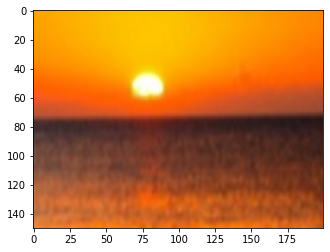

In [85]:
plt.imshow(X)

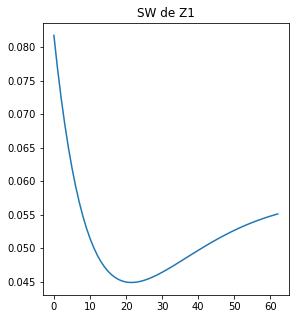

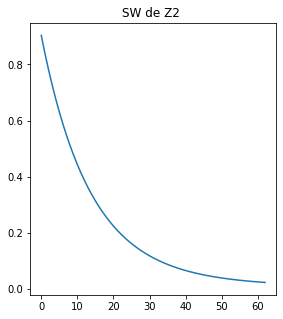

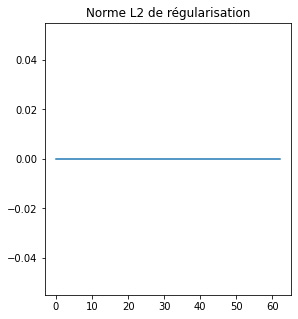

In [86]:
plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.plot(SW_Z1)
plt.title("SW de Z1")

plt.figure(figsize=(15,5))
plt.subplot(1,3,2)
plt.plot(SW_Z2)
plt.title("SW de Z2 ")

plt.figure(figsize=(15,5))
plt.subplot(1,3,3)
plt.plot(NormeL2)
plt.title("Norme L2 de régularisation")

plt.show()

In [87]:
print("erreur PSNR : ", PSNR(Xtrue, X))
print("erreur SAM : ", aSAM(Xtrue, X))
print("erreur aSSIM : ", acSSIM(Xtrue, X))

erreur PSNR :  79.4976240146017
erreur SAM :  0.02197451796720397
erreur aSSIM :  0.0988550397653496


In [88]:
print("PSNR de X barre : ", PSNR(Xtrue, reech_interp_interp_interph_interph_interp(L_H, 2)))

PSNR de X barre :  79.45053730674816


$\lambda_1 = 10$, $\lambda_2 = 1$, $\mu = 0$. Pas de régularisation pour vérifier la SW, et pondération plus grande pour la SW 1

In [89]:
X, Fct, SW_Z1, SW_Z2, NormeL2 = gradientDescente_pasConstant(L_H, L_M, 2, 1, 3, 10, 1, 0, 10, 0.01)

iter =  1 pas =  0.01 fonction =  1.410666298684467
iter =  2 pas =  0.01 fonction =  1.2541356683185307
iter =  3 pas =  0.01 fonction =  1.1206923333229604
iter =  4 pas =  0.01 fonction =  1.0069089648265814
iter =  5 pas =  0.01 fonction =  0.9096853065755097
iter =  6 pas =  0.01 fonction =  0.8265751181585921
iter =  7 pas =  0.01 fonction =  0.7553386050385289
iter =  8 pas =  0.01 fonction =  0.6941673580019906
iter =  9 pas =  0.01 fonction =  0.6416079155167871
iter =  10 pas =  0.01 fonction =  0.5962715065476176
iter =  11 pas =  0.01 fonction =  0.5571433348329451
iter =  12 pas =  0.01 fonction =  0.5232996922846984
iter =  13 pas =  0.01 fonction =  0.4939538501729883
iter =  14 pas =  0.01 fonction =  0.4684686468416288
iter =  15 pas =  0.01 fonction =  0.44629690740011285
iter =  16 pas =  0.01 fonction =  0.42698928938723035
iter =  17 pas =  0.01 fonction =  0.410134843394205
iter =  18 pas =  0.01 fonction =  0.3953794803065878
iter =  19 pas =  0.01 fonction =  0.

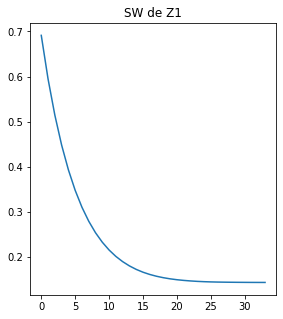

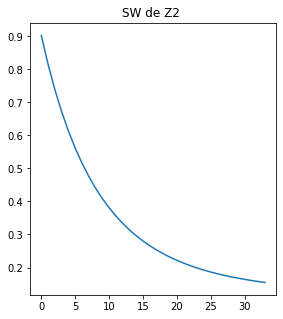

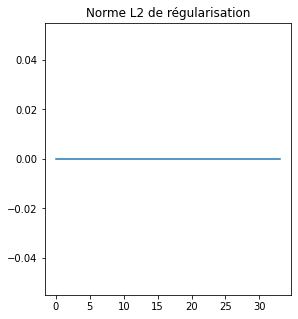

In [91]:
plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.plot(SW_Z1)
plt.title("SW de Z1")

plt.figure(figsize=(15,5))
plt.subplot(1,3,2)
plt.plot(SW_Z2)
plt.title("SW de Z2 ")

plt.figure(figsize=(15,5))
plt.subplot(1,3,3)
plt.plot(NormeL2)
plt.title("Norme L2 de régularisation")

plt.show()

In [92]:
print("erreur PSNR : ", PSNR(Xtrue, X))
print("erreur SAM : ", aSAM(Xtrue, X))
print("erreur aSSIM : ", acSSIM(Xtrue, X))

erreur PSNR :  79.55707900111037
erreur SAM :  0.021403888620172038
erreur aSSIM :  0.09744568357864658


In [93]:
print("PSNR de X barre : ", PSNR(Xtrue, reech_interp(L_H, 2)))

PSNR de X barre :  79.45053730674816


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'Image reconstruite par SW')

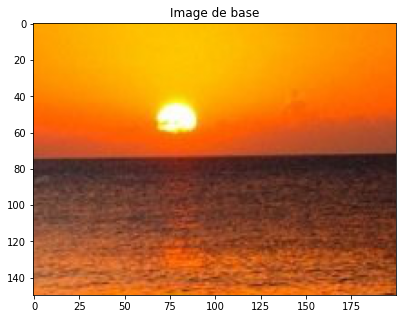

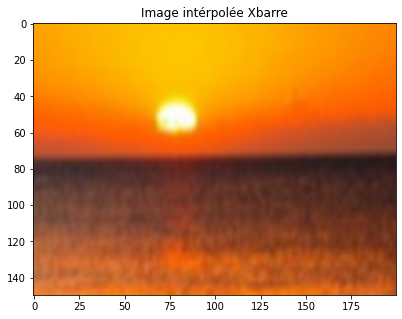

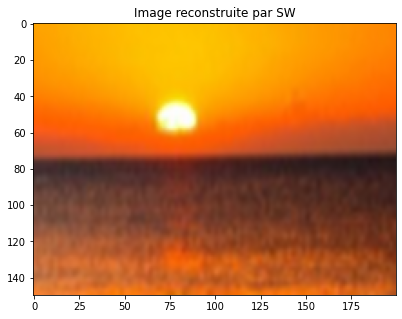

In [98]:
plt.figure(figsize=(15,5))
plt.imshow(Xtrue)
plt.title("Image de base")

plt.figure(figsize=(15,5))
plt.imshow(reech_interp(L_H, 2))
plt.title("Image intérpolée Xbarre")

plt.figure(figsize=(15,5))
plt.imshow(X)
plt.title("Image reconstruite par SW")

$\lambda_1 = 10$, $\lambda_2 = 1$, $\mu = 0$. Pas de régularisation pour vérifier la SW, et pondération plus grande pour la SW 1, et pas constant à 0.1

In [99]:
X, Fct, SW_Z1, SW_Z2, NormeL2 = gradientDescente_pasConstant(L_H, L_M, 2, 1, 3, 10, 1, 0, 10, 0.1)

iter =  1 pas =  0.1 fonction =  0.6790694706204047
iter =  2 pas =  0.1 fonction =  0.45403747996929045
iter =  3 pas =  0.1 fonction =  0.388356173935795
iter =  4 pas =  0.1 fonction =  0.362628422026079
iter =  5 pas =  0.1 fonction =  0.34791595146242577
iter =  6 pas =  0.1 fonction =  0.33847062626098334
iter =  7 pas =  0.1 fonction =  0.3309585336118904
iter =  8 pas =  0.1 fonction =  0.32399645755977613
iter =  9 pas =  0.1 fonction =  0.31833056993407194
iter =  10 pas =  0.1 fonction =  0.31395361545810563
iter =  11 pas =  0.1 fonction =  0.31039533809759556
iter =  12 pas =  0.1 fonction =  0.30696194208108096
iter =  13 pas =  0.1 fonction =  0.3037599476665448


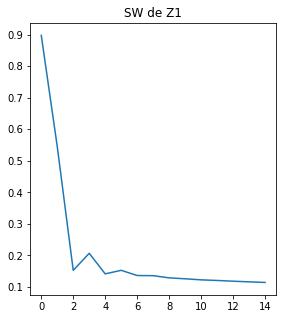

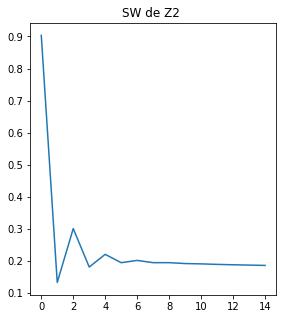

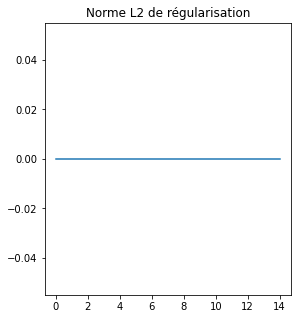

In [100]:
plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.plot(SW_Z1)
plt.title("SW de Z1")

plt.figure(figsize=(15,5))
plt.subplot(1,3,2)
plt.plot(SW_Z2)
plt.title("SW de Z2 ")

plt.figure(figsize=(15,5))
plt.subplot(1,3,3)
plt.plot(NormeL2)
plt.title("Norme L2 de régularisation")

plt.show()

In [101]:
print("erreur PSNR : ", PSNR(Xtrue, X))
print("erreur SAM : ", aSAM(Xtrue, X))
print("erreur aSSIM : ", acSSIM(Xtrue, X))
print("PSNR de X barre : ", PSNR(Xtrue, reech_interp(L_H, 2)))

erreur PSNR :  79.57472039337513
erreur SAM :  0.02170060888112521
erreur aSSIM :  0.09687261224997312
PSNR de X barre :  79.45053730674816


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'Image reconstruite par SW')

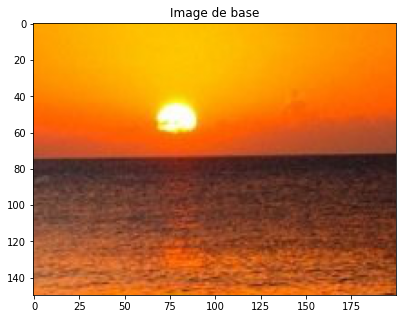

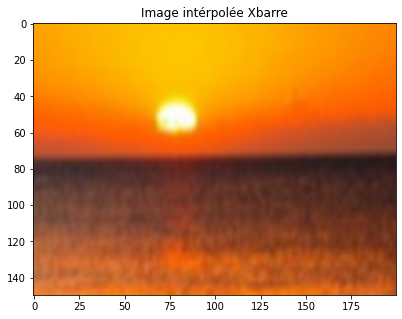

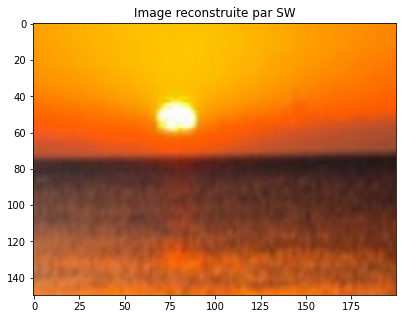

In [102]:
plt.figure(figsize=(15,5))
plt.imshow(Xtrue)
plt.title("Image de base")

plt.figure(figsize=(15,5))
plt.imshow(reech_interp(L_H, 2))
plt.title("Image intérpolée Xbarre")

plt.figure(figsize=(15,5))
plt.imshow(X)
plt.title("Image reconstruite par SW")

$\lambda_1 = 10$, $\lambda_2 = 1$, $\mu = 0.01$, pas constant à 0.01

In [103]:
X, Fct, SW_Z1, SW_Z2, NormeL2 = gradientDescente_pasConstant(L_H, L_M, 2, 1, 3, 10, 1, 0.01, 10, 0.01)

iter =  1 pas =  0.01 fonction =  1.5083117372275072
iter =  2 pas =  0.01 fonction =  1.2977029409075294
iter =  3 pas =  0.01 fonction =  1.132293038214703
iter =  4 pas =  0.01 fonction =  1.0015550641465771
iter =  5 pas =  0.01 fonction =  0.897496000372649
iter =  6 pas =  0.01 fonction =  0.814140692155342
iter =  7 pas =  0.01 fonction =  0.746919147139161
iter =  8 pas =  0.01 fonction =  0.6921924756086905
iter =  9 pas =  0.01 fonction =  0.6472014703605136
iter =  10 pas =  0.01 fonction =  0.6099949730200761
iter =  11 pas =  0.01 fonction =  0.5790617136708945
iter =  12 pas =  0.01 fonction =  0.5531039172764252
iter =  13 pas =  0.01 fonction =  0.5311559327878356
iter =  14 pas =  0.01 fonction =  0.5123354613481442
iter =  15 pas =  0.01 fonction =  0.49614948219977717
iter =  16 pas =  0.01 fonction =  0.48213591255459054
iter =  17 pas =  0.01 fonction =  0.4699195815594889
iter =  18 pas =  0.01 fonction =  0.45918511661927175
iter =  19 pas =  0.01 fonction =  0.4

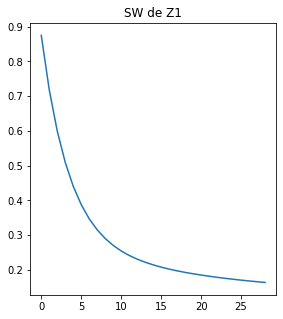

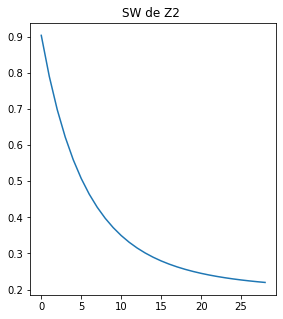

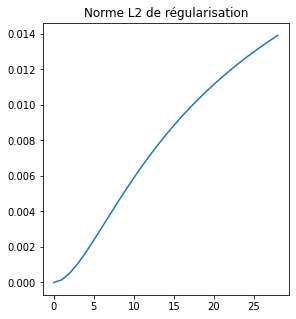

In [104]:
plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.plot(SW_Z1)
plt.title("SW de Z1")

plt.figure(figsize=(15,5))
plt.subplot(1,3,2)
plt.plot(SW_Z2)
plt.title("SW de Z2 ")

plt.figure(figsize=(15,5))
plt.subplot(1,3,3)
plt.plot(NormeL2)
plt.title("Norme L2 de régularisation")

plt.show()

In [105]:
print("erreur PSNR : ", PSNR(Xtrue, X))
print("erreur SAM : ", aSAM(Xtrue, X))
print("erreur aSSIM : ", acSSIM(Xtrue, X))
print("PSNR de X barre : ", PSNR(Xtrue, reech_interp(L_H, 2)))

erreur PSNR :  79.56518332403473
erreur SAM :  0.02133527417536763
erreur aSSIM :  0.09721472750809601
PSNR de X barre :  79.45053730674816


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'Image reconstruite par SW')

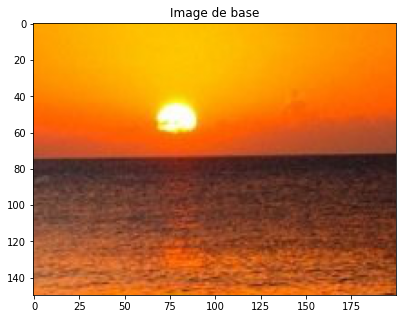

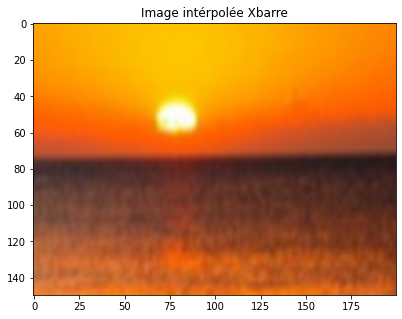

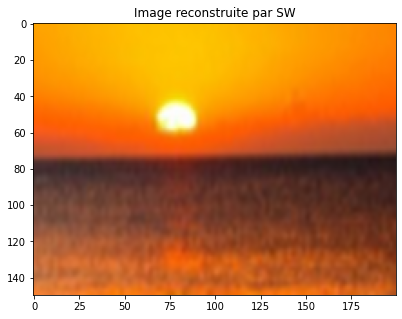

In [106]:
plt.figure(figsize=(15,5))
plt.imshow(Xtrue)
plt.title("Image de base")

plt.figure(figsize=(15,5))
plt.imshow(reech_interp(L_H, 2))
plt.title("Image intérpolée Xbarre")

plt.figure(figsize=(15,5))
plt.imshow(X)
plt.title("Image reconstruite par SW")

Plusieurs valeurs de $\mu$ et pour $\lambda_1 = 10$ et $\lambda_2 = 1$

iter =  1 pas =  0.01 fonction =  1.4476857547995643
iter =  2 pas =  0.01 fonction =  1.2242472816436947
iter =  3 pas =  0.01 fonction =  1.0561597346236
iter =  4 pas =  0.01 fonction =  0.9282744815344314
iter =  5 pas =  0.01 fonction =  0.830081321769119
iter =  6 pas =  0.01 fonction =  0.753890359894225
iter =  7 pas =  0.01 fonction =  0.6941339435349242
iter =  8 pas =  0.01 fonction =  0.6466050815939066
iter =  9 pas =  0.01 fonction =  0.6083342867171441
iter =  10 pas =  0.01 fonction =  0.5771570316054241
iter =  11 pas =  0.01 fonction =  0.5514559224391244
iter =  12 pas =  0.01 fonction =  0.5299066872538755
iter =  13 pas =  0.01 fonction =  0.5116394650243375
iter =  14 pas =  0.01 fonction =  0.4959586282992586
iter =  15 pas =  0.01 fonction =  0.48245106348589
iter =  16 pas =  0.01 fonction =  0.4706929171535641
iter =  17 pas =  0.01 fonction =  0.4603591118532706
iter =  18 pas =  0.01 fonction =  0.4512140904152426
iter =  19 pas =  0.01 fonction =  0.4430683

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Image reconstruire pour mu = 0.001
Fonctionnelle pour mu = 0.001


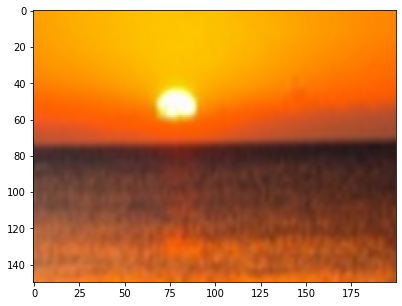

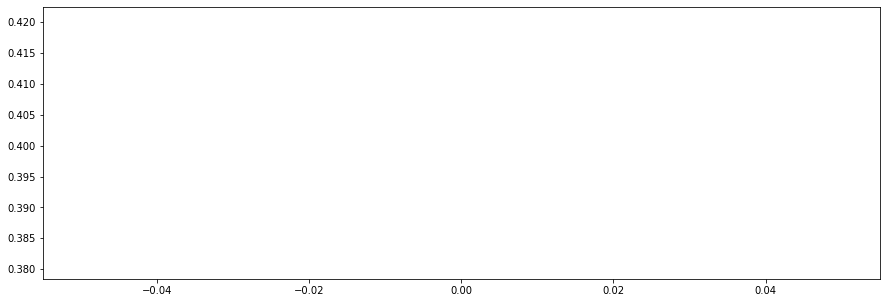

iter =  1 pas =  0.01 fonction =  1.2919506714751683
iter =  2 pas =  0.01 fonction =  1.1705980536353588
iter =  3 pas =  0.01 fonction =  1.0653867378063124
iter =  4 pas =  0.01 fonction =  0.9738444868198354
iter =  5 pas =  0.01 fonction =  0.8939803504223032
iter =  6 pas =  0.01 fonction =  0.8240694150111579
iter =  7 pas =  0.01 fonction =  0.7627087966062716
iter =  8 pas =  0.01 fonction =  0.708657417781624
iter =  9 pas =  0.01 fonction =  0.6609155025141259
iter =  10 pas =  0.01 fonction =  0.6186403443981894
iter =  11 pas =  0.01 fonction =  0.5810522876379123
iter =  12 pas =  0.01 fonction =  0.5475892715829122
iter =  13 pas =  0.01 fonction =  0.517723344183017
iter =  14 pas =  0.01 fonction =  0.4910028748671264
iter =  15 pas =  0.01 fonction =  0.46705742526454
iter =  16 pas =  0.01 fonction =  0.4455755200960325
iter =  17 pas =  0.01 fonction =  0.4262400806732081
iter =  18 pas =  0.01 fonction =  0.40884182715476275
iter =  19 pas =  0.01 fonction =  0.393

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Image reconstruire pour mu = 0.01
Fonctionnelle pour mu = 0.01


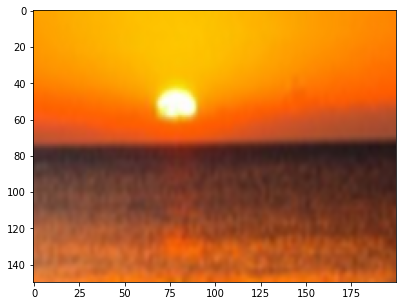

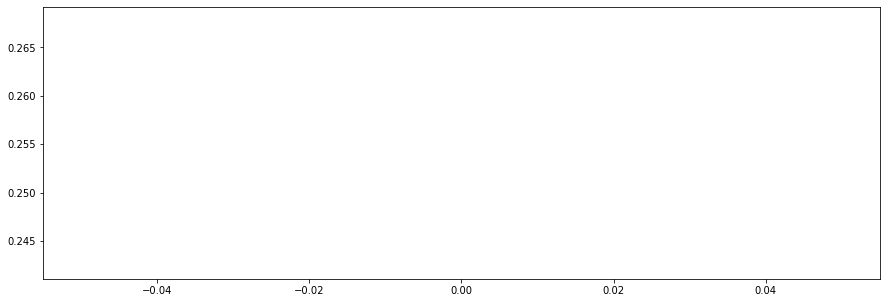

iter =  1 pas =  0.01 fonction =  1.2014490778685434
iter =  2 pas =  0.01 fonction =  1.0606234170875561
iter =  3 pas =  0.01 fonction =  0.9429474512055451
iter =  4 pas =  0.01 fonction =  0.8443190843990143
iter =  5 pas =  0.01 fonction =  0.7613850918070777
iter =  6 pas =  0.01 fonction =  0.6914267836216178
iter =  7 pas =  0.01 fonction =  0.6322102026018207
iter =  8 pas =  0.01 fonction =  0.581911749850918
iter =  9 pas =  0.01 fonction =  0.5390604897220719
iter =  10 pas =  0.01 fonction =  0.5024421609926305
iter =  11 pas =  0.01 fonction =  0.47100532402952705
iter =  12 pas =  0.01 fonction =  0.4439651396544946
iter =  13 pas =  0.01 fonction =  0.4206180361349455
iter =  14 pas =  0.01 fonction =  0.40037402241017883
iter =  15 pas =  0.01 fonction =  0.3827978641598055
iter =  16 pas =  0.01 fonction =  0.3674723145945217
iter =  17 pas =  0.01 fonction =  0.3540814822708731
iter =  18 pas =  0.01 fonction =  0.3423363603062196
iter =  19 pas =  0.01 fonction =  0

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Image reconstruire pour mu = 0.01
Fonctionnelle pour mu = 0.01


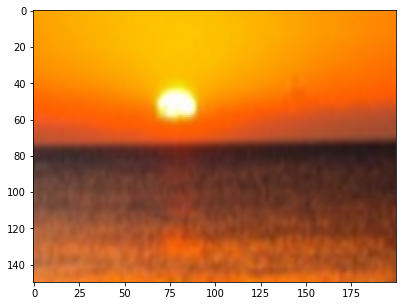

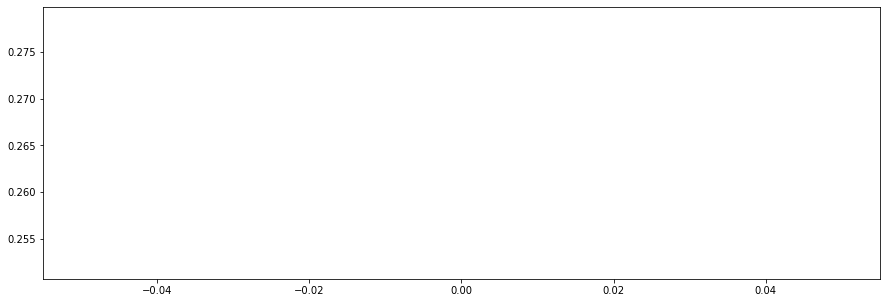

iter =  1 pas =  0.01 fonction =  1.3682378724077184
iter =  2 pas =  0.01 fonction =  1.1646454364898158
iter =  3 pas =  0.01 fonction =  1.0134861162787079
iter =  4 pas =  0.01 fonction =  0.9003966161092183
iter =  5 pas =  0.01 fonction =  0.8148958841933645
iter =  6 pas =  0.01 fonction =  0.7497896794720716
iter =  7 pas =  0.01 fonction =  0.6998875862083775
iter =  8 pas =  0.01 fonction =  0.6612553694068264
iter =  9 pas =  0.01 fonction =  0.6309651105411455
iter =  10 pas =  0.01 fonction =  0.6070082081207111
iter =  11 pas =  0.01 fonction =  0.587866843618861
iter =  12 pas =  0.01 fonction =  0.5724965336559108
iter =  13 pas =  0.01 fonction =  0.559982783213553
iter =  14 pas =  0.01 fonction =  0.5496713996368178
iter =  15 pas =  0.01 fonction =  0.5410756631049448
iter =  16 pas =  0.01 fonction =  0.5337476258509244
iter =  17 pas =  0.01 fonction =  0.5275325430417288
iter =  18 pas =  0.01 fonction =  0.522256224125903


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Image reconstruire pour mu = 0.1
Fonctionnelle pour mu = 0.1


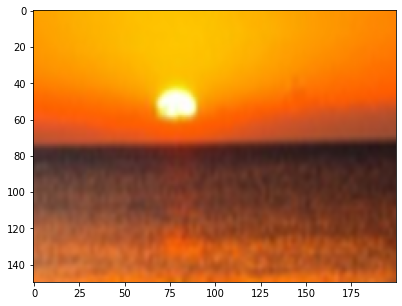

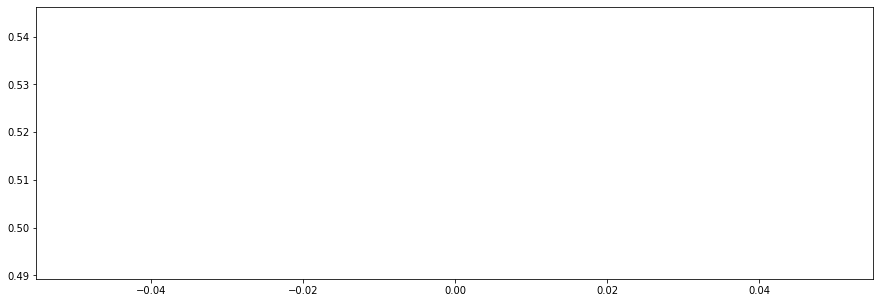

iter =  1 pas =  0.01 fonction =  1.5402201693306505
iter =  2 pas =  0.01 fonction =  1.338410380703019
iter =  3 pas =  0.01 fonction =  1.214696165638421
iter =  4 pas =  0.01 fonction =  1.143066641665669
iter =  5 pas =  0.01 fonction =  1.1059376194806565
iter =  6 pas =  0.01 fonction =  1.0913854249304824


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Image reconstruire pour mu = 1
Fonctionnelle pour mu = 1


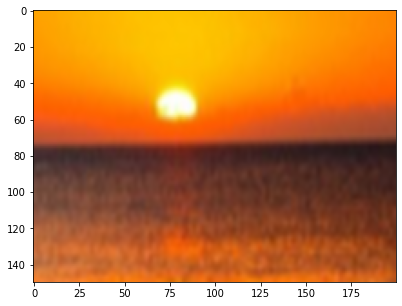

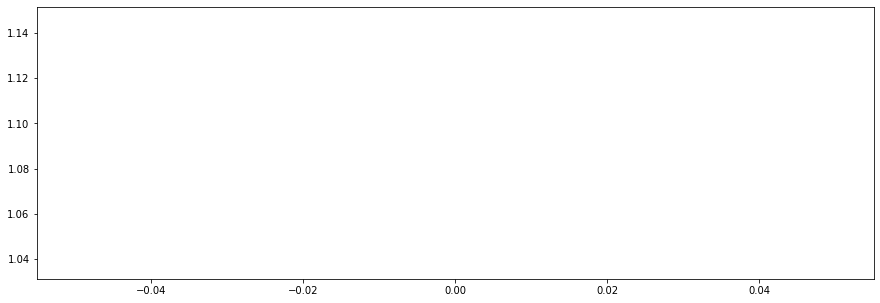

NameError: name 'K_ech' is not defined

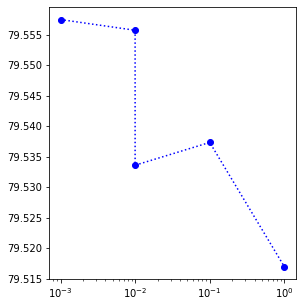

In [109]:
mu = [0.001, 0.01, 0.01, 0.1, 1]
errPSNR = []
errASAM = []
errACSSIM = []
for i in range(len(mu)):
    X, Fct, SW_Z1, SW_Z2, NormeL2 = gradientDescente_pasConstant(L_H, L_M, 2, 1, 3, 10, 1, mu[i], 10, 0.01)
    errPSNR.append(PSNR(Xtrue, X))
    errASAM.append(aSAM(Xtrue, X))
    errACSSIM.append(acSSIM(Xtrue, X))
    print('Image reconstruire pour mu = '+str(mu[i])+'')
    plt.figure(figsize=(15,5))
    plt.imshow(X)
    print('Fonctionnelle pour mu = '+str(mu[i])+'')
    plt.figure(figsize=(15,5))
    plt.plot(Fct)
    plt.show()

plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.semilogx(mu,errPSNR, "b:o")
plt.axhline(PSNR(Xtrue, reech_interp(L_H, K_ech)), color='red')
plt.title("PSNR à l'image théorique")

plt.figure(figsize=(15,5))
plt.subplot(1,3,2)
plt.semilogx(mu, errASAM, "b:o")
plt.axhline(aSAM(Xtrue, reech_interp(L_H, K_ech)), color='red')
plt.title("average SAM erreur spectrale à l'image théorique ")

plt.figure(figsize=(15,5))
plt.subplot(1,3,3)
plt.semilogx(mu,errACSSIM, "b:o")
plt.axhline(acSSIM(Xtrue, reech_interp(L_H, K_ech)), color='red')
plt.title("average SSIM erreur spatiale à l'image théorique")

plt.show()

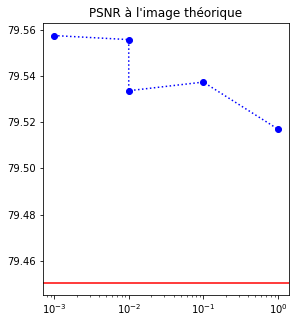

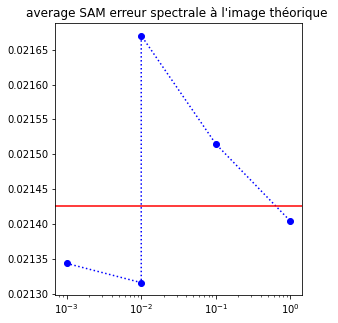

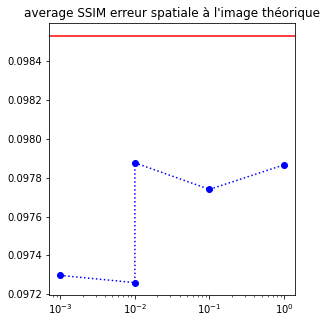

In [110]:
plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.semilogx(mu,errPSNR, "b:o")
plt.axhline(PSNR(Xtrue, reech_interp(L_H, 2)), color='red')
plt.title("PSNR à l'image théorique")

plt.figure(figsize=(15,5))
plt.subplot(1,3,2)
plt.semilogx(mu, errASAM, "b:o")
plt.axhline(aSAM(Xtrue, reech_interp(L_H, 2)), color='red')
plt.title("average SAM erreur spectrale à l'image théorique ")

plt.figure(figsize=(15,5))
plt.subplot(1,3,3)
plt.semilogx(mu,errACSSIM, "b:o")
plt.axhline(acSSIM(Xtrue, reech_interp(L_H, 2)), color='red')
plt.title("average SSIM erreur spatiale à l'image théorique")

plt.show()

# Pas optimal

$\lambda_1 = 10$, $\lambda_2 = 1$, $\mu = 0$. Pas de régularisation pour vérifier la SW, avec pas à recherche linéaire

In [20]:
X, Fct, SW_Z1, SW_Z2, NormeL2 = gradientDescente_pasRL(L_H, L_M, 2, 1, 3, 10, 1, 0, 10)

iter =  1 pas =  0.25 fonction =  0.4626843291748388
iter =  2 pas =  0.125 fonction =  0.38998877211254124
iter =  3 pas =  0.125 fonction =  0.23288559109189305
iter =  4 pas =  0.125 fonction =  0.1961341107496294
iter =  5 pas =  0.25 fonction =  0.18134754735530723


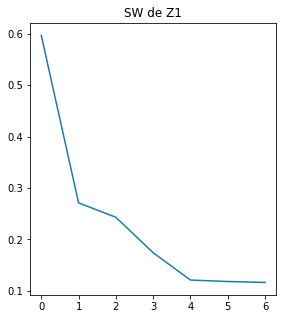

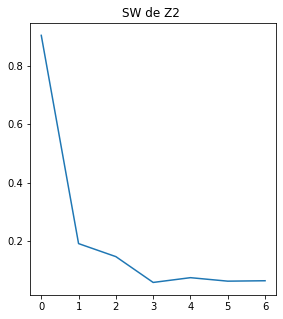

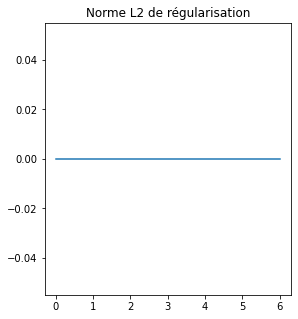

In [21]:
plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.plot(SW_Z1)
plt.title("SW de Z1")

plt.figure(figsize=(15,5))
plt.subplot(1,3,2)
plt.plot(SW_Z2)
plt.title("SW de Z2 ")

plt.figure(figsize=(15,5))
plt.subplot(1,3,3)
plt.plot(NormeL2)
plt.title("Norme L2 de régularisation")

plt.show()

In [22]:
print("erreur PSNR : ", PSNR(Xtrue, X))
print("erreur SAM : ", aSAM(Xtrue, X))
print("erreur aSSIM : ", acSSIM(Xtrue, X))
print("PSNR de X barre : ", PSNR(Xtrue, reech_interp(L_H, 2)))

erreur PSNR :  79.56413666302319
erreur SAM :  0.021889130705911763
erreur aSSIM :  0.09675318561788371
PSNR de X barre :  79.45053730674816


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'Image reconstruite par SW')

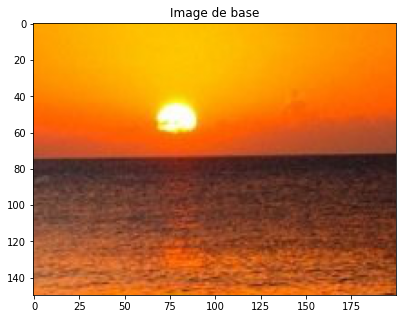

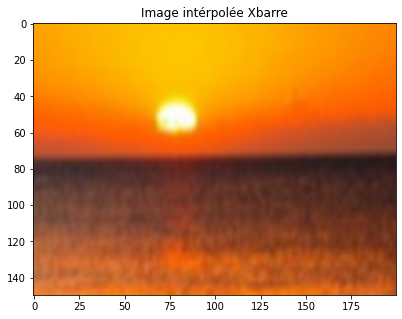

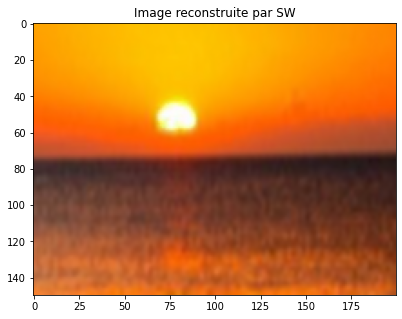

In [23]:
plt.figure(figsize=(15,5))
plt.imshow(Xtrue)
plt.title("Image de base")

plt.figure(figsize=(15,5))
plt.imshow(reech_interp(L_H, 2))
plt.title("Image intérpolée Xbarre")

plt.figure(figsize=(15,5))
plt.imshow(X)
plt.title("Image reconstruite par SW")

$\lambda_1 = 10$, $\lambda_2 = 1$, $\mu = 0.01$. Petite régularisation pour vérifier la SW, avec pas à recherche linéaire

In [26]:
X, Fct, SW_Z1, SW_Z2, NormeL2 = gradientDescente_pasRL(L_H, L_M, 2, 1, 3, 10, 1, 0.01, 10)

iter =  1 pas =  0.125 fonction =  0.511898037649796
iter =  2 pas =  0.125 fonction =  0.3483445880914205
iter =  3 pas =  0.125 fonction =  0.30234013206422744
iter =  4 pas =  0.125 fonction =  0.2786801818199335
iter =  5 pas =  0.125 fonction =  0.2659669488508556
iter =  6 pas =  0.125 fonction =  0.2566570020556236
iter =  7 pas =  0.125 fonction =  0.2507289560796829
iter =  8 pas =  0.125 fonction =  0.24673968045410521
iter =  9 pas =  0.125 fonction =  0.2441220584705076


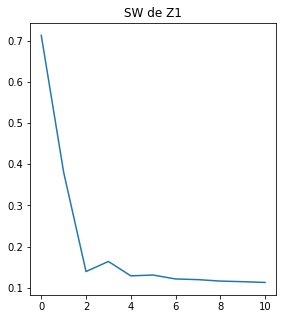

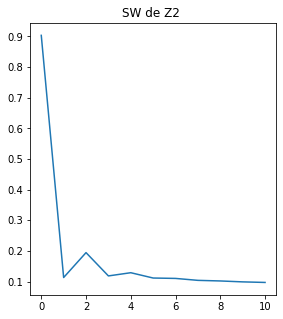

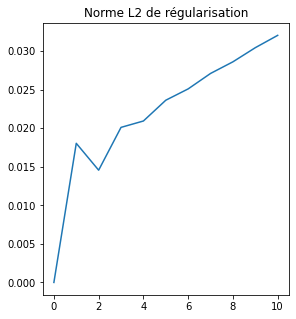

In [27]:
plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.plot(SW_Z1)
plt.title("SW de Z1")

plt.figure(figsize=(15,5))
plt.subplot(1,3,2)
plt.plot(SW_Z2)
plt.title("SW de Z2 ")

plt.figure(figsize=(15,5))
plt.subplot(1,3,3)
plt.plot(NormeL2)
plt.title("Norme L2 de régularisation")

plt.show()

In [28]:
print("erreur PSNR : ", PSNR(Xtrue, X))
print("erreur SAM : ", aSAM(Xtrue, X))
print("erreur aSSIM : ", acSSIM(Xtrue, X))
print("PSNR de X barre : ", PSNR(Xtrue, reech_interp(L_H, 2)))

erreur PSNR :  79.56104178796149
erreur SAM :  0.022297590684337804
erreur aSSIM :  0.09726088820839474
PSNR de X barre :  79.45053730674816


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'Image reconstruite par SW')

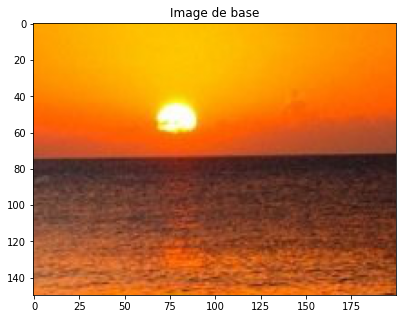

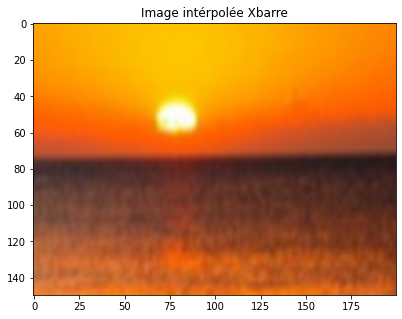

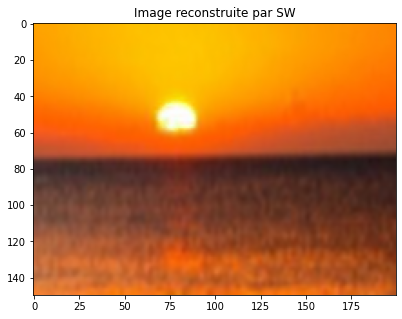

In [29]:
plt.figure(figsize=(15,5))
plt.imshow(Xtrue)
plt.title("Image de base")

plt.figure(figsize=(15,5))
plt.imshow(reech_interp(L_H, 2))
plt.title("Image intérpolée Xbarre")

plt.figure(figsize=(15,5))
plt.imshow(X)
plt.title("Image reconstruite par SW")

Résolution gradient pour mu = 0.01
iter =  1 pas =  0.125 fonction =  0.7896840032421253
iter =  2 pas =  0.0625 fonction =  0.6802161272412582
iter =  3 pas =  0.25 fonction =  0.3661931990297005
iter =  4 pas =  0.125 fonction =  0.33742816916082596
iter =  5 pas =  0.125 fonction =  0.32500780732678985
iter =  6 pas =  0.0625 fonction =  0.32036666698279864
iter =  7 pas =  0.25 fonction =  0.31153594564133547


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Image reconstruire pour mu = 0.01


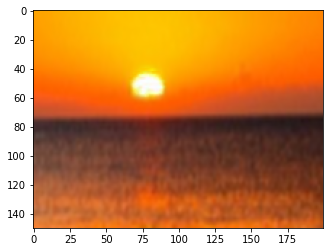

Fonctionnelle pour mu = 0.01


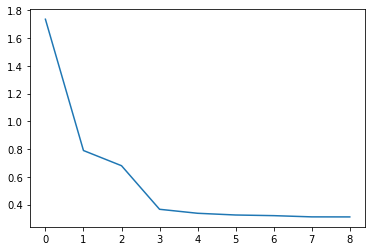

Résolution gradient pour mu = 0.01291549665014884
iter =  1 pas =  0.125 fonction =  0.709263945771641
iter =  2 pas =  0.125 fonction =  0.4385096441877503
iter =  3 pas =  0.125 fonction =  0.36192243178221156
iter =  4 pas =  0.125 fonction =  0.3273904651408285
iter =  5 pas =  0.25 fonction =  0.31302312845233415
iter =  6 pas =  0.125 fonction =  0.30515519996594703
iter =  7 pas =  0.125 fonction =  0.29533204287106485
iter =  8 pas =  0.125 fonction =  0.289639818959127


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Image reconstruire pour mu = 0.01291549665014884


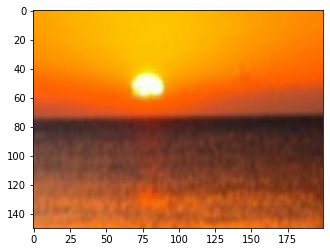

Fonctionnelle pour mu = 0.01291549665014884


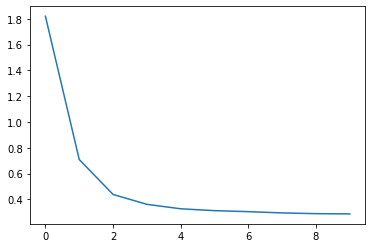

Résolution gradient pour mu = 0.016681005372000592
iter =  1 pas =  0.0625 fonction =  1.4042785519774883
iter =  2 pas =  0.25 fonction =  0.4486556590738776
iter =  3 pas =  0.125 fonction =  0.4064649100528998
iter =  4 pas =  0.125 fonction =  0.39269065124352326


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Image reconstruire pour mu = 0.016681005372000592


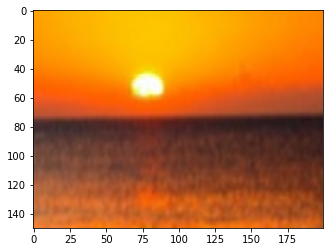

Fonctionnelle pour mu = 0.016681005372000592


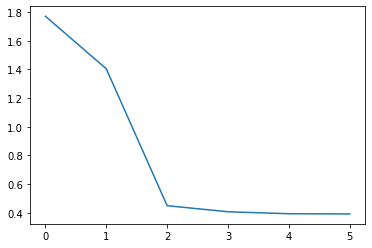

Résolution gradient pour mu = 0.021544346900318832
iter =  1 pas =  0.125 fonction =  0.5155800111130276
iter =  2 pas =  0.125 fonction =  0.37074595467707994
iter =  3 pas =  0.25 fonction =  0.3429574685822126
iter =  4 pas =  0.125 fonction =  0.33433140650266185
iter =  5 pas =  0.125 fonction =  0.3205805904943727
iter =  6 pas =  0.125 fonction =  0.31377107579791963


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Image reconstruire pour mu = 0.021544346900318832


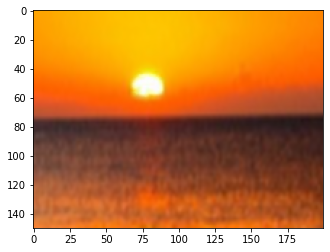

Fonctionnelle pour mu = 0.021544346900318832


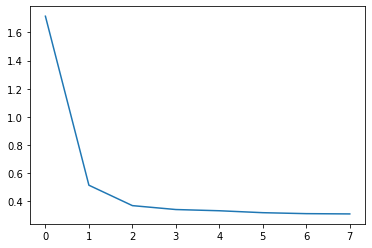

Résolution gradient pour mu = 0.027825594022071243
iter =  1 pas =  0.125 fonction =  0.9820255838978862
iter =  2 pas =  0.125 fonction =  0.762571034235871
iter =  3 pas =  0.125 fonction =  0.6814190757701135
iter =  4 pas =  0.125 fonction =  0.5893369743920228
iter =  5 pas =  0.125 fonction =  0.5582686585545462
iter =  6 pas =  0.125 fonction =  0.5035140573002869
iter =  7 pas =  0.125 fonction =  0.49018166198241114
iter =  8 pas =  0.125 fonction =  0.45490451075382504


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Image reconstruire pour mu = 0.027825594022071243


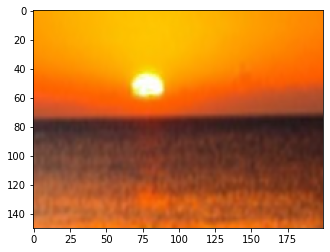

Fonctionnelle pour mu = 0.027825594022071243


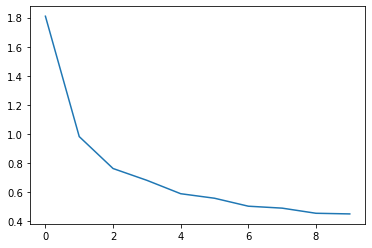

Résolution gradient pour mu = 0.03593813663804628
iter =  1 pas =  0.125 fonction =  1.095371255571336
iter =  2 pas =  0.125 fonction =  0.8005809491049828
iter =  3 pas =  0.125 fonction =  0.6955183172372614
iter =  4 pas =  0.125 fonction =  0.5700668140322931
iter =  5 pas =  0.125 fonction =  0.536191386237268
iter =  6 pas =  0.125 fonction =  0.4719244809962111
iter =  7 pas =  0.125 fonction =  0.4626768692206672
iter =  8 pas =  0.0625 fonction =  0.4272646186974302
iter =  9 pas =  0 fonction =  0.37480943090104146


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Image reconstruire pour mu = 0.03593813663804628


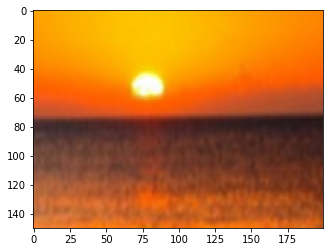

Fonctionnelle pour mu = 0.03593813663804628


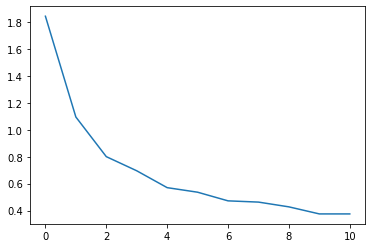

Résolution gradient pour mu = 0.046415888336127774
iter =  1 pas =  0.125 fonction =  0.5387526300859855
iter =  2 pas =  0.125 fonction =  0.39161563898580076
iter =  3 pas =  0.125 fonction =  0.3762594881167435
iter =  4 pas =  0.125 fonction =  0.3663965821690486


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Image reconstruire pour mu = 0.046415888336127774


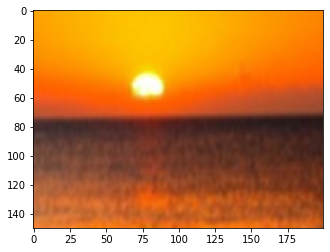

Fonctionnelle pour mu = 0.046415888336127774


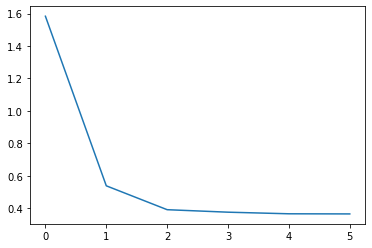

Résolution gradient pour mu = 0.05994842503189409
iter =  1 pas =  0.125 fonction =  0.7981397411213459
iter =  2 pas =  0.125 fonction =  0.5193444274684657
iter =  3 pas =  0.125 fonction =  0.48298247766093316
iter =  4 pas =  0.0625 fonction =  0.4479560131780479


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Image reconstruire pour mu = 0.05994842503189409


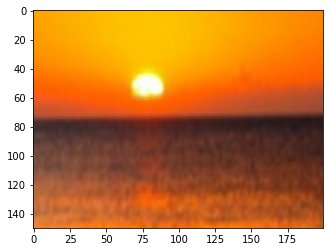

Fonctionnelle pour mu = 0.05994842503189409


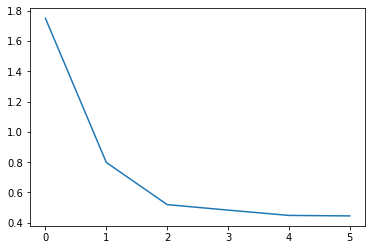

Résolution gradient pour mu = 0.0774263682681127
iter =  1 pas =  0.125 fonction =  0.6638279426111009
iter =  2 pas =  0.125 fonction =  0.46767308179204126


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Image reconstruire pour mu = 0.0774263682681127


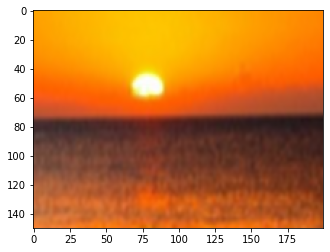

Fonctionnelle pour mu = 0.0774263682681127


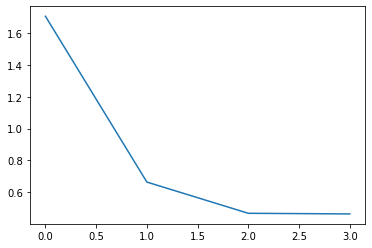

Résolution gradient pour mu = 0.1
iter =  1 pas =  0.125 fonction =  1.3482814719674243
iter =  2 pas =  0.125 fonction =  0.9591097575006019
iter =  3 pas =  0.125 fonction =  0.948160527512971
iter =  4 pas =  0.0625 fonction =  0.7453280987546214
iter =  5 pas =  0 fonction =  0.5265426582471191


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Image reconstruire pour mu = 0.1


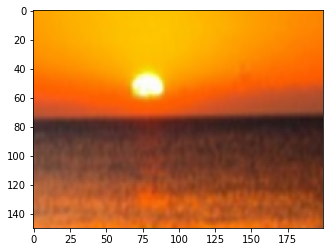

Fonctionnelle pour mu = 0.1


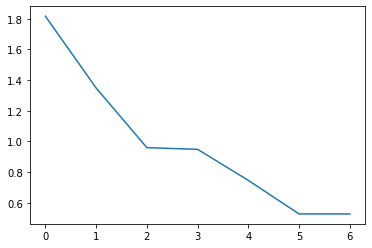

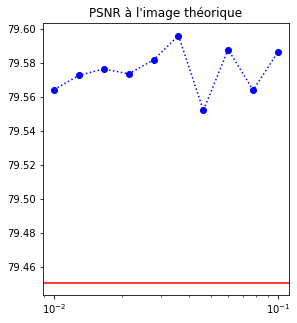

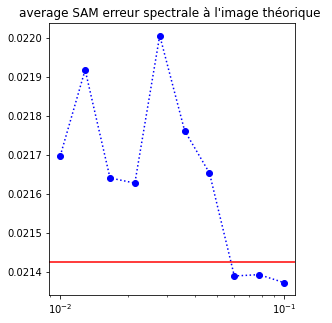

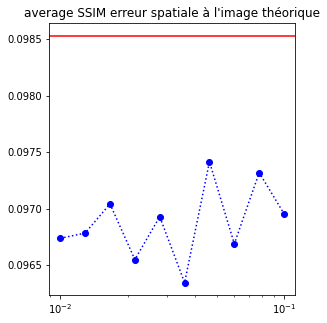

In [46]:
mu = np.logspace(-2, -1, 10, endpoint=True)
errPSNR = []
errASAM = []
errACSSIM = []
for i in range(len(mu)):
    print('Résolution gradient pour mu = '+str(mu[i])+'')
    X, Fct, SW_Z1, SW_Z2, NormeL2 = gradientDescente_pasRL(L_H, L_M, 2, 1, 3, 10, 1, mu[i], 10)
    errPSNR.append(PSNR(Xtrue, X))
    errASAM.append(aSAM(Xtrue, X))
    errACSSIM.append(acSSIM(Xtrue, X))
    print('Image reconstruire pour mu = '+str(mu[i])+'')
    plt.imshow(X)
    plt.show()
    print('Fonctionnelle pour mu = '+str(mu[i])+'')
    plt.plot(Fct)
    plt.show()

plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.semilogx(mu,errPSNR, "b:o")
plt.axhline(PSNR(Xtrue, reech_interp(L_H, 2)), color='red')
plt.title("PSNR à l'image théorique")

plt.figure(figsize=(15,5))
plt.subplot(1,3,2)
plt.semilogx(mu, errASAM, "b:o")
plt.axhline(aSAM(Xtrue, reech_interp(L_H, 2)), color='red')
plt.title("average SAM erreur spectrale à l'image théorique ")

plt.figure(figsize=(15,5))
plt.subplot(1,3,3)
plt.semilogx(mu,errACSSIM, "b:o")
plt.axhline(acSSIM(Xtrue, reech_interp(L_H, 2)), color='red')
plt.title("average SSIM erreur spatiale à l'image théorique")

plt.show()

Résolution gradient pour mu = 0.01
iter =  1 pas =  0.01 fonction =  1.4346297873911522
iter =  2 pas =  0.01 fonction =  1.250728760591108
iter =  3 pas =  0.01 fonction =  1.1000392029296633
iter =  4 pas =  0.01 fonction =  0.9762573366314509
iter =  5 pas =  0.01 fonction =  0.8742684799396967
iter =  6 pas =  0.01 fonction =  0.7900268483824605
iter =  7 pas =  0.01 fonction =  0.7202013515284879
iter =  8 pas =  0.01 fonction =  0.6621938834760056
iter =  9 pas =  0.01 fonction =  0.6138455019038183
iter =  10 pas =  0.01 fonction =  0.5733970673243105
iter =  11 pas =  0.01 fonction =  0.5394076856270369
iter =  12 pas =  0.01 fonction =  0.5107356811327634
iter =  13 pas =  0.01 fonction =  0.48650412831576634
iter =  14 pas =  0.01 fonction =  0.4658877362582686
iter =  15 pas =  0.01 fonction =  0.44826772725225894
iter =  16 pas =  0.01 fonction =  0.4331431670525046
iter =  17 pas =  0.01 fonction =  0.42012164123816165
iter =  18 pas =  0.01 fonction =  0.4088200994711984


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Image reconstruire pour mu = 0.01


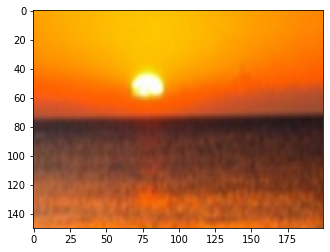

Fonctionnelle pour mu = 0.01


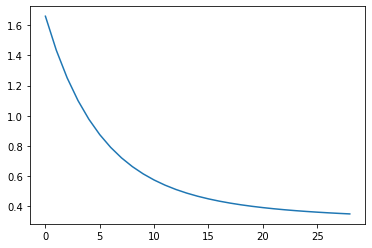

Résolution gradient pour mu = 0.01291549665014884
iter =  1 pas =  0.01 fonction =  1.5282669624871197
iter =  2 pas =  0.01 fonction =  1.3144857215189023
iter =  3 pas =  0.01 fonction =  1.1419993750212336
iter =  4 pas =  0.01 fonction =  1.0026072048622807
iter =  5 pas =  0.01 fonction =  0.8896581127616187
iter =  6 pas =  0.01 fonction =  0.7979623708312047
iter =  7 pas =  0.01 fonction =  0.723167595451933
iter =  8 pas =  0.01 fonction =  0.6619659628835197
iter =  9 pas =  0.01 fonction =  0.611793337724021
iter =  10 pas =  0.01 fonction =  0.5705873310726578
iter =  11 pas =  0.01 fonction =  0.5365708853488014
iter =  12 pas =  0.01 fonction =  0.5084313672862938
iter =  13 pas =  0.01 fonction =  0.48501208288366743
iter =  14 pas =  0.01 fonction =  0.4654286914936788
iter =  15 pas =  0.01 fonction =  0.448995694201195
iter =  16 pas =  0.01 fonction =  0.43512585561334904
iter =  17 pas =  0.01 fonction =  0.42338372625572507
iter =  18 pas =  0.01 fonction =  0.4133

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Image reconstruire pour mu = 0.01291549665014884


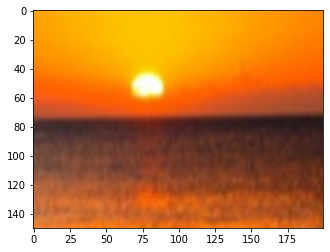

Fonctionnelle pour mu = 0.01291549665014884


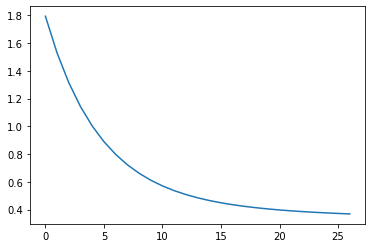

Résolution gradient pour mu = 0.016681005372000592
iter =  1 pas =  0.01 fonction =  1.533617746465052
iter =  2 pas =  0.01 fonction =  1.3329624312555939
iter =  3 pas =  0.01 fonction =  1.1696943250882714
iter =  4 pas =  0.01 fonction =  1.0365345147122025
iter =  5 pas =  0.01 fonction =  0.9276125383065806
iter =  6 pas =  0.01 fonction =  0.838157964988349
iter =  7 pas =  0.01 fonction =  0.7645871427004983
iter =  8 pas =  0.01 fonction =  0.7039366391945787
iter =  9 pas =  0.01 fonction =  0.6538020744130967
iter =  10 pas =  0.01 fonction =  0.6121543381349026
iter =  11 pas =  0.01 fonction =  0.5772775576430349
iter =  12 pas =  0.01 fonction =  0.5480063058995943
iter =  13 pas =  0.01 fonction =  0.5234164220832098
iter =  14 pas =  0.01 fonction =  0.5026700736105908
iter =  15 pas =  0.01 fonction =  0.48506191854969893
iter =  16 pas =  0.01 fonction =  0.4700144025183507
iter =  17 pas =  0.01 fonction =  0.4571339093841499
iter =  18 pas =  0.01 fonction =  0.4460

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Image reconstruire pour mu = 0.016681005372000592


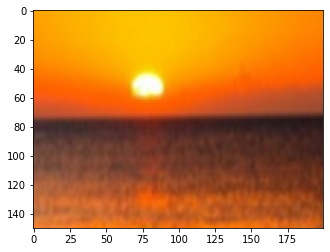

Fonctionnelle pour mu = 0.016681005372000592


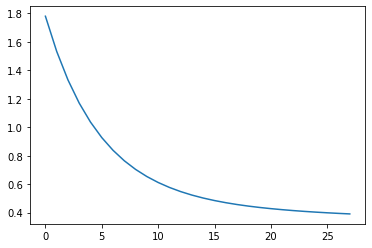

Résolution gradient pour mu = 0.021544346900318832
iter =  1 pas =  0.01 fonction =  1.4512976036950866
iter =  2 pas =  0.01 fonction =  1.2039090552914968
iter =  3 pas =  0.01 fonction =  1.0227368809725241
iter =  4 pas =  0.01 fonction =  0.888891466278553
iter =  5 pas =  0.01 fonction =  0.78908177586855
iter =  6 pas =  0.01 fonction =  0.7136823588458157
iter =  7 pas =  0.01 fonction =  0.6560730644274403
iter =  8 pas =  0.01 fonction =  0.6114810521455869
iter =  9 pas =  0.01 fonction =  0.5764867508459267
iter =  10 pas =  0.01 fonction =  0.54858478563827
iter =  11 pas =  0.01 fonction =  0.5259314954144314
iter =  12 pas =  0.01 fonction =  0.5072249288933025
iter =  13 pas =  0.01 fonction =  0.4915606775211897
iter =  14 pas =  0.01 fonction =  0.4782666608523966
iter =  15 pas =  0.01 fonction =  0.4668565144041727
iter =  16 pas =  0.01 fonction =  0.4569336290624228
iter =  17 pas =  0.01 fonction =  0.4482344620516442
iter =  18 pas =  0.01 fonction =  0.44055264

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Image reconstruire pour mu = 0.021544346900318832


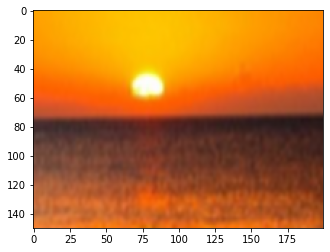

Fonctionnelle pour mu = 0.021544346900318832


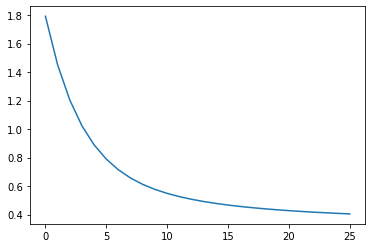

Résolution gradient pour mu = 0.027825594022071243
iter =  1 pas =  0.01 fonction =  1.310397809716563
iter =  2 pas =  0.01 fonction =  1.150348606953138
iter =  3 pas =  0.01 fonction =  1.0191334989407368
iter =  4 pas =  0.01 fonction =  0.9112986110424677
iter =  5 pas =  0.01 fonction =  0.8223742122708814
iter =  6 pas =  0.01 fonction =  0.748864712700111
iter =  7 pas =  0.01 fonction =  0.6879129278124959
iter =  8 pas =  0.01 fonction =  0.6372163645066642
iter =  9 pas =  0.01 fonction =  0.5949274510093373
iter =  10 pas =  0.01 fonction =  0.5594778388048243
iter =  11 pas =  0.01 fonction =  0.5296552783501323
iter =  12 pas =  0.01 fonction =  0.5044518930731813
iter =  13 pas =  0.01 fonction =  0.4830785357088539
iter =  14 pas =  0.01 fonction =  0.4648836144121392
iter =  15 pas =  0.01 fonction =  0.4492939191950037
iter =  16 pas =  0.01 fonction =  0.4358874438273646
iter =  17 pas =  0.01 fonction =  0.42431015939162503
iter =  18 pas =  0.01 fonction =  0.41425

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Image reconstruire pour mu = 0.027825594022071243


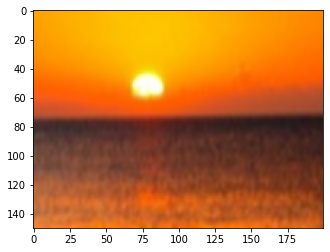

Fonctionnelle pour mu = 0.027825594022071243


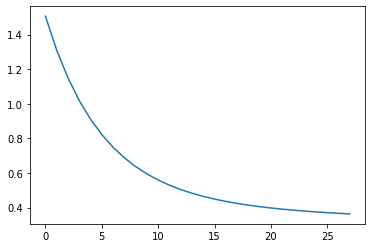

Résolution gradient pour mu = 0.03593813663804628
iter =  1 pas =  0.01 fonction =  1.35767649505257
iter =  2 pas =  0.01 fonction =  1.1890660246080205
iter =  3 pas =  0.01 fonction =  1.052719531143647
iter =  4 pas =  0.01 fonction =  0.9421424990536799
iter =  5 pas =  0.01 fonction =  0.8522142503896669
iter =  6 pas =  0.01 fonction =  0.7787076034214251
iter =  7 pas =  0.01 fonction =  0.7183405448144166
iter =  8 pas =  0.01 fonction =  0.6685297937739565
iter =  9 pas =  0.01 fonction =  0.6272299840382536
iter =  10 pas =  0.01 fonction =  0.5928763159011522
iter =  11 pas =  0.01 fonction =  0.5641325304593914
iter =  12 pas =  0.01 fonction =  0.5400022953518703
iter =  13 pas =  0.01 fonction =  0.519660337999043
iter =  14 pas =  0.01 fonction =  0.502391333573656
iter =  15 pas =  0.01 fonction =  0.48765842864712
iter =  16 pas =  0.01 fonction =  0.47501289093729954
iter =  17 pas =  0.01 fonction =  0.46408175294883913
iter =  18 pas =  0.01 fonction =  0.454559098

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Image reconstruire pour mu = 0.03593813663804628


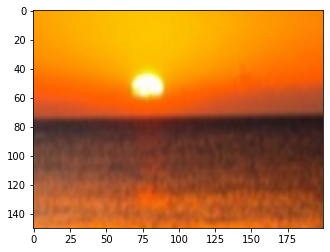

Fonctionnelle pour mu = 0.03593813663804628


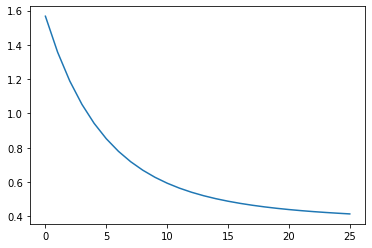

Résolution gradient pour mu = 0.046415888336127774
iter =  1 pas =  0.01 fonction =  1.4713265976009817
iter =  2 pas =  0.01 fonction =  1.2250363647656035
iter =  3 pas =  0.01 fonction =  1.0428368394696834
iter =  4 pas =  0.01 fonction =  0.9067965890683489
iter =  5 pas =  0.01 fonction =  0.8041132664353018
iter =  6 pas =  0.01 fonction =  0.7256328831723045
iter =  7 pas =  0.01 fonction =  0.6648071893718018
iter =  8 pas =  0.01 fonction =  0.6169379496816707
iter =  9 pas =  0.01 fonction =  0.5786901502696471
iter =  10 pas =  0.01 fonction =  0.5476321479886997
iter =  11 pas =  0.01 fonction =  0.5219611380610616
iter =  12 pas =  0.01 fonction =  0.5003812014518882
iter =  13 pas =  0.01 fonction =  0.4819620152091557
iter =  14 pas =  0.01 fonction =  0.46600593399685053
iter =  15 pas =  0.01 fonction =  0.45199984104234575
iter =  16 pas =  0.01 fonction =  0.43958262895929967
iter =  17 pas =  0.01 fonction =  0.42847228275554855
iter =  18 pas =  0.01 fonction =  0

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Image reconstruire pour mu = 0.046415888336127774


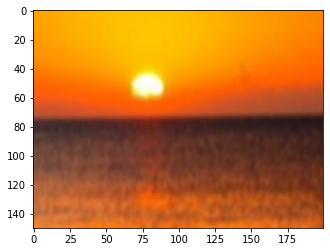

Fonctionnelle pour mu = 0.046415888336127774


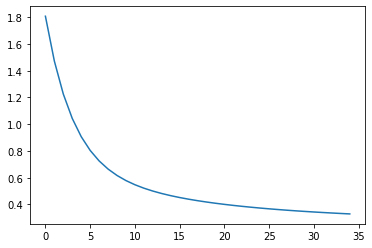

Résolution gradient pour mu = 0.05994842503189409
iter =  1 pas =  0.01 fonction =  1.5754190069561111
iter =  2 pas =  0.01 fonction =  1.3333298893867538
iter =  3 pas =  0.01 fonction =  1.1477123598363956
iter =  4 pas =  0.01 fonction =  1.0046731065465684
iter =  5 pas =  0.01 fonction =  0.8937226615900176
iter =  6 pas =  0.01 fonction =  0.8071572685265412
iter =  7 pas =  0.01 fonction =  0.7391738038702335
iter =  8 pas =  0.01 fonction =  0.6854115693335779
iter =  9 pas =  0.01 fonction =  0.6425143327043089
iter =  10 pas =  0.01 fonction =  0.6079487156068177
iter =  11 pas =  0.01 fonction =  0.5798560178240104
iter =  12 pas =  0.01 fonction =  0.5568105964791258
iter =  13 pas =  0.01 fonction =  0.5377601410018509
iter =  14 pas =  0.01 fonction =  0.521823343477334
iter =  15 pas =  0.01 fonction =  0.5083554557799523
iter =  16 pas =  0.01 fonction =  0.49690127225090475
iter =  17 pas =  0.01 fonction =  0.4870690020882347
iter =  18 pas =  0.01 fonction =  0.4785

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Image reconstruire pour mu = 0.05994842503189409


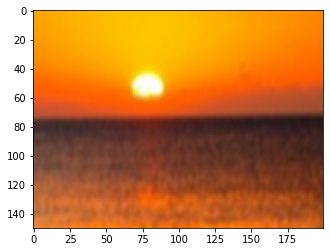

Fonctionnelle pour mu = 0.05994842503189409


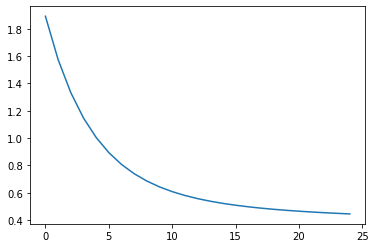

Résolution gradient pour mu = 0.0774263682681127
iter =  1 pas =  0.01 fonction =  1.427739859576985
iter =  2 pas =  0.01 fonction =  1.252426345094765
iter =  3 pas =  0.01 fonction =  1.1129962351448963
iter =  4 pas =  0.01 fonction =  1.001265512267473
iter =  5 pas =  0.01 fonction =  0.9111489253525447
iter =  6 pas =  0.01 fonction =  0.83797860333159
iter =  7 pas =  0.01 fonction =  0.7781757595836774
iter =  8 pas =  0.01 fonction =  0.729039644071215
iter =  9 pas =  0.01 fonction =  0.6884360469274406
iter =  10 pas =  0.01 fonction =  0.654570827613645
iter =  11 pas =  0.01 fonction =  0.6261649715314571
iter =  12 pas =  0.01 fonction =  0.6022320381260834
iter =  13 pas =  0.01 fonction =  0.5818896668639884
iter =  14 pas =  0.01 fonction =  0.5645875787028849
iter =  15 pas =  0.01 fonction =  0.5498078500666586
iter =  16 pas =  0.01 fonction =  0.5371312609168608
iter =  17 pas =  0.01 fonction =  0.5262017818130873
iter =  18 pas =  0.01 fonction =  0.516681995900

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Image reconstruire pour mu = 0.0774263682681127


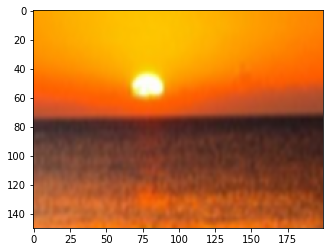

Fonctionnelle pour mu = 0.0774263682681127


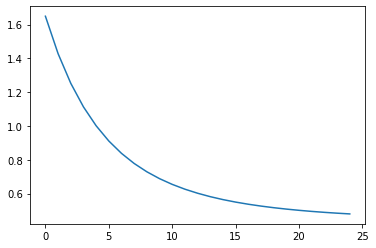

Résolution gradient pour mu = 0.1
iter =  1 pas =  0.01 fonction =  1.3817013679473162
iter =  2 pas =  0.01 fonction =  1.2048851324338714
iter =  3 pas =  0.01 fonction =  1.0665076275804923
iter =  4 pas =  0.01 fonction =  0.9578272078106318
iter =  5 pas =  0.01 fonction =  0.8720731875011839
iter =  6 pas =  0.01 fonction =  0.804070769744709
iter =  7 pas =  0.01 fonction =  0.7498340253681903
iter =  8 pas =  0.01 fonction =  0.7061792299589116
iter =  9 pas =  0.01 fonction =  0.6708757079912879
iter =  10 pas =  0.01 fonction =  0.6421851143670375
iter =  11 pas =  0.01 fonction =  0.6186454067562887
iter =  12 pas =  0.01 fonction =  0.5992526340722186
iter =  13 pas =  0.01 fonction =  0.5831706903877197
iter =  14 pas =  0.01 fonction =  0.5697145304565888
iter =  15 pas =  0.01 fonction =  0.5584158217189059
iter =  16 pas =  0.01 fonction =  0.5488487654784316
iter =  17 pas =  0.01 fonction =  0.5407243403963347
iter =  18 pas =  0.01 fonction =  0.533761545039404
iter 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Image reconstruire pour mu = 0.1


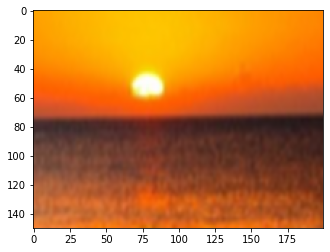

Fonctionnelle pour mu = 0.1


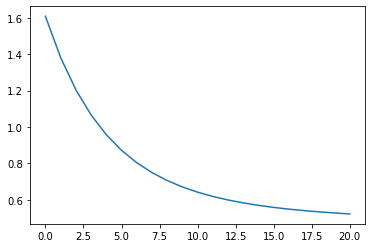

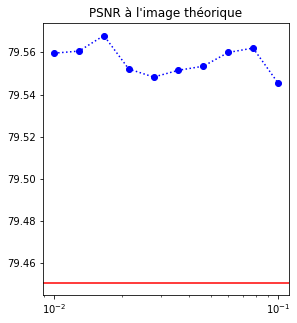

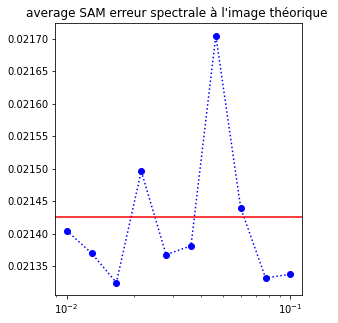

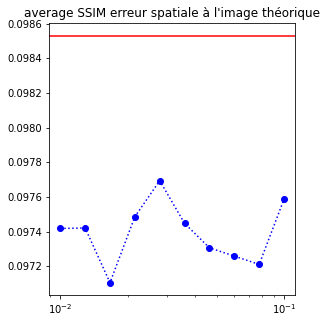

In [48]:
mu = np.logspace(-2, -1, 10, endpoint=True)
errPSNR = []
errASAM = []
errACSSIM = []
for i in range(len(mu)):
    print('Résolution gradient pour mu = '+str(mu[i])+'')
    X, Fct, SW_Z1, SW_Z2, NormeL2 = gradientDescente_pasConstant(L_H, L_M, 2, 1, 3, 10, 1, mu[i], 10, 0.01)
    errPSNR.append(PSNR(Xtrue, X))
    errASAM.append(aSAM(Xtrue, X))
    errACSSIM.append(acSSIM(Xtrue, X))
    print('Image reconstruire pour mu = '+str(mu[i])+'')
    plt.imshow(X)
    plt.show()
    print('Fonctionnelle pour mu = '+str(mu[i])+'')
    plt.plot(Fct)
    plt.show()

plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.semilogx(mu,errPSNR, "b:o")
plt.axhline(PSNR(Xtrue, reech_interp(L_H, 2)), color='red')
plt.title("PSNR à l'image théorique")

plt.figure(figsize=(15,5))
plt.subplot(1,3,2)
plt.semilogx(mu, errASAM, "b:o")
plt.axhline(aSAM(Xtrue, reech_interp(L_H, 2)), color='red')
plt.title("average SAM erreur spectrale à l'image théorique ")

plt.figure(figsize=(15,5))
plt.subplot(1,3,3)
plt.semilogx(mu,errACSSIM, "b:o")
plt.axhline(acSSIM(Xtrue, reech_interp(L_H, 2)), color='red')
plt.title("average SSIM erreur spatiale à l'image théorique")

plt.show()

# Grosse simu pour voir l'influence de l'aléatoire

In [49]:
mu_opt = mu[2]

In [50]:
mu_opt

0.016681005372000592

In [51]:
tirages = 50

In [53]:
errPSNR = []
errASAM = []
errACSSIM = []
for i in range(tirages):
    X, Fct, SW_Z1, SW_Z2, NormeL2 = gradientDescente_pasConstant(L_H, L_M, 2, 1, 3, 10, 1, mu_opt, 10, 0.01)
    errPSNR.append(PSNR(Xtrue, X))
    errASAM.append(aSAM(Xtrue, X))
    errACSSIM.append(acSSIM(Xtrue, X))


iter =  1 pas =  0.01 fonction =  1.3447328322470364
iter =  2 pas =  0.01 fonction =  1.1923873627045452
iter =  3 pas =  0.01 fonction =  1.064679991049893
iter =  4 pas =  0.01 fonction =  0.9574948819837591
iter =  5 pas =  0.01 fonction =  0.8673540831702654
iter =  6 pas =  0.01 fonction =  0.7913591194408772
iter =  7 pas =  0.01 fonction =  0.7271247751489442
iter =  8 pas =  0.01 fonction =  0.6727433203361918
iter =  9 pas =  0.01 fonction =  0.6265486338136376
iter =  10 pas =  0.01 fonction =  0.5871800971254383
iter =  11 pas =  0.01 fonction =  0.5536356842055357
iter =  12 pas =  0.01 fonction =  0.5249436739483603
iter =  13 pas =  0.01 fonction =  0.5003483321052467
iter =  14 pas =  0.01 fonction =  0.4792256715254827
iter =  15 pas =  0.01 fonction =  0.4610167045942306
iter =  16 pas =  0.01 fonction =  0.44519447391794026
iter =  17 pas =  0.01 fonction =  0.431455030162249
iter =  18 pas =  0.01 fonction =  0.4194504696841889
iter =  19 pas =  0.01 fonction =  0.4

iter =  22 pas =  0.01 fonction =  0.3712571016859851
iter =  23 pas =  0.01 fonction =  0.3650879888884368
iter =  24 pas =  0.01 fonction =  0.35956386773765514
iter =  25 pas =  0.01 fonction =  0.354590872860656
iter =  26 pas =  0.01 fonction =  0.350114191872247
iter =  27 pas =  0.01 fonction =  0.3460685873643958
iter =  28 pas =  0.01 fonction =  0.3423962446860613
iter =  1 pas =  0.01 fonction =  1.2887455497106555
iter =  2 pas =  0.01 fonction =  1.1162393267415645
iter =  3 pas =  0.01 fonction =  0.9807112852317785
iter =  4 pas =  0.01 fonction =  0.8735672063116213
iter =  5 pas =  0.01 fonction =  0.7882316755394928
iter =  6 pas =  0.01 fonction =  0.7197495446327259
iter =  7 pas =  0.01 fonction =  0.6645248031140677
iter =  8 pas =  0.01 fonction =  0.6195894430628451
iter =  9 pas =  0.01 fonction =  0.5827488354261667
iter =  10 pas =  0.01 fonction =  0.5523211677950113
iter =  11 pas =  0.01 fonction =  0.5269628944336766
iter =  12 pas =  0.01 fonction =  0.5

iter =  11 pas =  0.01 fonction =  0.5291826901379879
iter =  12 pas =  0.01 fonction =  0.5009861424613056
iter =  13 pas =  0.01 fonction =  0.47736580716637583
iter =  14 pas =  0.01 fonction =  0.4575029572287917
iter =  15 pas =  0.01 fonction =  0.44071876065980625
iter =  16 pas =  0.01 fonction =  0.42645840143807273
iter =  17 pas =  0.01 fonction =  0.41426818327968346
iter =  18 pas =  0.01 fonction =  0.4037486589511485
iter =  19 pas =  0.01 fonction =  0.3946538186398531
iter =  20 pas =  0.01 fonction =  0.3867328566126884
iter =  21 pas =  0.01 fonction =  0.3798052703250317
iter =  22 pas =  0.01 fonction =  0.3737084705879907
iter =  23 pas =  0.01 fonction =  0.36829678787341846
iter =  24 pas =  0.01 fonction =  0.3635030171777691
iter =  25 pas =  0.01 fonction =  0.359187802521253
iter =  26 pas =  0.01 fonction =  0.35528878453751156
iter =  1 pas =  0.01 fonction =  1.4443637726139547
iter =  2 pas =  0.01 fonction =  1.251194705773496
iter =  3 pas =  0.01 fonc

iter =  5 pas =  0.01 fonction =  0.8992059232011509
iter =  6 pas =  0.01 fonction =  0.8060855871343136
iter =  7 pas =  0.01 fonction =  0.7300143015943343
iter =  8 pas =  0.01 fonction =  0.6677327470322902
iter =  9 pas =  0.01 fonction =  0.6166326457886048
iter =  10 pas =  0.01 fonction =  0.574434065326357
iter =  11 pas =  0.01 fonction =  0.5395440027855916
iter =  12 pas =  0.01 fonction =  0.5105547719577476
iter =  13 pas =  0.01 fonction =  0.4862864464348924
iter =  14 pas =  0.01 fonction =  0.4659540513930917
iter =  15 pas =  0.01 fonction =  0.44881953607162695
iter =  16 pas =  0.01 fonction =  0.4343279997382912
iter =  17 pas =  0.01 fonction =  0.42191920058023313
iter =  18 pas =  0.01 fonction =  0.4112430560776555
iter =  19 pas =  0.01 fonction =  0.40205825385677085
iter =  20 pas =  0.01 fonction =  0.3940367779744428
iter =  21 pas =  0.01 fonction =  0.38704503773466803
iter =  22 pas =  0.01 fonction =  0.3809024200808229
iter =  23 pas =  0.01 fonctio

iter =  17 pas =  0.01 fonction =  0.4580979987819665
iter =  18 pas =  0.01 fonction =  0.4477621916422185
iter =  19 pas =  0.01 fonction =  0.43860934877553837
iter =  20 pas =  0.01 fonction =  0.4305251294851186
iter =  21 pas =  0.01 fonction =  0.4233313283305785
iter =  22 pas =  0.01 fonction =  0.41685119112403124
iter =  23 pas =  0.01 fonction =  0.41098416479880256
iter =  24 pas =  0.01 fonction =  0.40564345870784063
iter =  25 pas =  0.01 fonction =  0.40079529305057254
iter =  26 pas =  0.01 fonction =  0.3964023510955366
iter =  27 pas =  0.01 fonction =  0.3923700065129722
iter =  1 pas =  0.01 fonction =  1.269239414719908
iter =  2 pas =  0.01 fonction =  1.1497407958958101
iter =  3 pas =  0.01 fonction =  1.0454400039532292
iter =  4 pas =  0.01 fonction =  0.954185170631125
iter =  5 pas =  0.01 fonction =  0.8742391780709023
iter =  6 pas =  0.01 fonction =  0.8040163953013901
iter =  7 pas =  0.01 fonction =  0.742219032870699
iter =  8 pas =  0.01 fonction = 

iter =  10 pas =  0.01 fonction =  0.5724939401675304
iter =  11 pas =  0.01 fonction =  0.5497217874540841
iter =  12 pas =  0.01 fonction =  0.5308794514973512
iter =  13 pas =  0.01 fonction =  0.51507582023235
iter =  14 pas =  0.01 fonction =  0.501725373296255
iter =  15 pas =  0.01 fonction =  0.49029619033696353
iter =  16 pas =  0.01 fonction =  0.48040499518499735
iter =  17 pas =  0.01 fonction =  0.47180767232568704
iter =  18 pas =  0.01 fonction =  0.46427902712072266
iter =  19 pas =  0.01 fonction =  0.45758556285118124
iter =  20 pas =  0.01 fonction =  0.4515707619475905
iter =  21 pas =  0.01 fonction =  0.44615862438758125
iter =  22 pas =  0.01 fonction =  0.4412494404792902
iter =  23 pas =  0.01 fonction =  0.4367788220014611
iter =  1 pas =  0.01 fonction =  1.4194595191729638
iter =  2 pas =  0.01 fonction =  1.244845349517261
iter =  3 pas =  0.01 fonction =  1.1018266186080958
iter =  4 pas =  0.01 fonction =  0.984311951540921
iter =  5 pas =  0.01 fonction 

iter =  15 pas =  0.01 fonction =  0.4602012482862415
iter =  16 pas =  0.01 fonction =  0.44568473721382185
iter =  17 pas =  0.01 fonction =  0.43309526608779686
iter =  18 pas =  0.01 fonction =  0.4221194144991119
iter =  19 pas =  0.01 fonction =  0.4125141110033534
iter =  20 pas =  0.01 fonction =  0.40409102519066753
iter =  21 pas =  0.01 fonction =  0.39664529870849097
iter =  22 pas =  0.01 fonction =  0.3900525032899875
iter =  23 pas =  0.01 fonction =  0.38417569559895337
iter =  24 pas =  0.01 fonction =  0.37891078596302324
iter =  25 pas =  0.01 fonction =  0.3741976655467405
iter =  26 pas =  0.01 fonction =  0.3699247341312172
iter =  27 pas =  0.01 fonction =  0.3660361614208134
iter =  1 pas =  0.01 fonction =  1.2824220406145188
iter =  2 pas =  0.01 fonction =  1.1282355708902223
iter =  3 pas =  0.01 fonction =  1.0012382011625853
iter =  4 pas =  0.01 fonction =  0.8962953563638286
iter =  5 pas =  0.01 fonction =  0.8092392009675244
iter =  6 pas =  0.01 fonct

iter =  23 pas =  0.01 fonction =  0.3431770744404598
iter =  24 pas =  0.01 fonction =  0.334578077894153
iter =  25 pas =  0.01 fonction =  0.32683660825543726
iter =  26 pas =  0.01 fonction =  0.31982162975452355
iter =  27 pas =  0.01 fonction =  0.31345098514273667
iter =  28 pas =  0.01 fonction =  0.30768969202081164
iter =  29 pas =  0.01 fonction =  0.30244062726739385
iter =  30 pas =  0.01 fonction =  0.29763883406951475
iter =  31 pas =  0.01 fonction =  0.2932410967506316
iter =  32 pas =  0.01 fonction =  0.2891863527281574
iter =  33 pas =  0.01 fonction =  0.2854393734664145
iter =  34 pas =  0.01 fonction =  0.2820057510038489
iter =  35 pas =  0.01 fonction =  0.2788549145343019
iter =  36 pas =  0.01 fonction =  0.27593554518242
iter =  1 pas =  0.01 fonction =  1.4039853033175234
iter =  2 pas =  0.01 fonction =  1.213120688814369
iter =  3 pas =  0.01 fonction =  1.0598330613318505
iter =  4 pas =  0.01 fonction =  0.9360458605130745
iter =  5 pas =  0.01 fonction

iter =  2 pas =  0.01 fonction =  1.27080198372894
iter =  3 pas =  0.01 fonction =  1.1080711402464958
iter =  4 pas =  0.01 fonction =  0.9790479157756914
iter =  5 pas =  0.01 fonction =  0.8762968068018588
iter =  6 pas =  0.01 fonction =  0.794070086894739
iter =  7 pas =  0.01 fonction =  0.7278588148022489
iter =  8 pas =  0.01 fonction =  0.6741971298522376
iter =  9 pas =  0.01 fonction =  0.6303974953740006
iter =  10 pas =  0.01 fonction =  0.5944680915884821
iter =  11 pas =  0.01 fonction =  0.5648325890600143
iter =  12 pas =  0.01 fonction =  0.5402028004988377
iter =  13 pas =  0.01 fonction =  0.5196242824952514
iter =  14 pas =  0.01 fonction =  0.502320034917792
iter =  15 pas =  0.01 fonction =  0.48765427771583
iter =  16 pas =  0.01 fonction =  0.47514123798449504
iter =  17 pas =  0.01 fonction =  0.46439243878362235
iter =  18 pas =  0.01 fonction =  0.4551060820426245
iter =  19 pas =  0.01 fonction =  0.44698152237487504
iter =  20 pas =  0.01 fonction =  0.43

iter =  9 pas =  0.01 fonction =  0.6005629887759091
iter =  10 pas =  0.01 fonction =  0.5697555923349907
iter =  11 pas =  0.01 fonction =  0.5440016133502008
iter =  12 pas =  0.01 fonction =  0.5222748441539459
iter =  13 pas =  0.01 fonction =  0.5037816069580038
iter =  14 pas =  0.01 fonction =  0.4879411463121659
iter =  15 pas =  0.01 fonction =  0.4741878944083247
iter =  16 pas =  0.01 fonction =  0.462167332600803
iter =  17 pas =  0.01 fonction =  0.4516205231045498
iter =  18 pas =  0.01 fonction =  0.44231162139093455
iter =  19 pas =  0.01 fonction =  0.4340277609306518
iter =  20 pas =  0.01 fonction =  0.4266227980588897
iter =  21 pas =  0.01 fonction =  0.41991852914471645
iter =  22 pas =  0.01 fonction =  0.4138826324106672
iter =  23 pas =  0.01 fonction =  0.4084141863940529
iter =  24 pas =  0.01 fonction =  0.4034257208231448
iter =  25 pas =  0.01 fonction =  0.3988877616818647
iter =  26 pas =  0.01 fonction =  0.39473785126752803


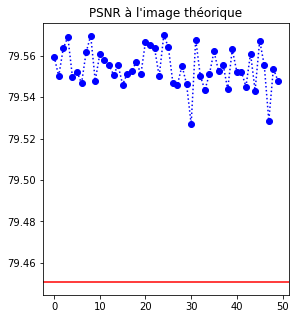

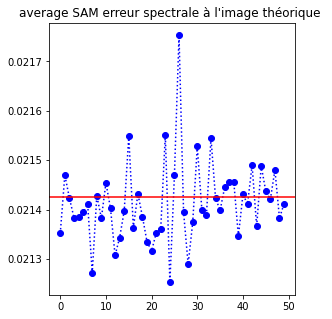

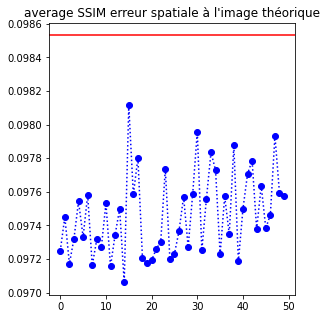

In [56]:
plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.plot(errPSNR, "b:o")
plt.axhline(PSNR(Xtrue, reech_interp(L_H, 2)), color='red')
plt.title("PSNR à l'image théorique")

plt.figure(figsize=(15,5))
plt.subplot(1,3,2)
plt.plot(errASAM, "b:o")
plt.axhline(aSAM(Xtrue, reech_interp(L_H, 2)), color='red')
plt.title("average SAM erreur spectrale à l'image théorique ")

plt.figure(figsize=(15,5))
plt.subplot(1,3,3)
plt.plot(errACSSIM, "b:o")
plt.axhline(acSSIM(Xtrue, reech_interp(L_H, 2)), color='red')
plt.title("average SSIM erreur spatiale à l'image théorique")

plt.show()